# Refine Feature Groups into Final Bins

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jax.config import config
#config.update("jax_enable_x64", True)

In [3]:
import datetime
import yaml
import itertools
from pathlib import Path

In [4]:
import jax
import jax.numpy as jnp
from jax.experimental import stax,optimizers

In [5]:
from zotbin.group import load_groups
from zotbin.reweight import reweighted_metrics
from zotbin.binned import load_binned
from zotbin.optimize import *

In [6]:
init_data = load_binned('binned_80_4k.npz')

## Framework for Running Studies

In [7]:
def save_study(kw, results, outpath):
    """Save results from a study.
    """
    nbin = kw['nbin']
    init_data = kw['init_data']
    best_scores, dndz_bin, all_scores = results
    np.savez(outpath / f'dndz-{nbin}.npz', dndz=dndz_bin, zedges=init_data[0])
    for scores in all_scores:
        plt.plot(scores, 'r-', alpha=0.3)
    plt.xlabel('Optimization step')
    plt.ylabel(kw.get('metric', 'Score'))
    plt.savefig(outpath / f'training-{nbin}.png')
    plt.show()
    plot_dndz(dndz_bin, init_data[0])
    plt.savefig(outpath / f'dndz-{nbin}.png')
    plt.show()
    with open(outpath / f'scores-{nbin}.yaml', 'w') as f:
        yaml.dump(best_scores, f)

In [8]:
def study_complete(nbin, outpath):
    """Check if a study has already been completed and saved.
    """
    return (outpath / f'scores-{nbin}.yaml').exists()

In [9]:
def run_study(path, func, rerun=[]):
    """Run a study configured by a yaml file.
    """
    path = Path(path)
    with open(path / 'config.yaml') as f:
        config = yaml.safe_load(f)
    nstudy = len(config['nbin'])
    argsiter = []
    argnames = config.keys()
    for arg in argnames:
        if not isinstance(config[arg], list):
            argsiter.append(itertools.repeat(config[arg]))
        elif len(config[arg]) != nstudy:
            print(f'Expected 1 or {nstudy} values for {arg}.')
            return
        else:
            argsiter.append(iter(config[arg]))
    for argvalues in zip(*argsiter):
        kw = dict(zip(argnames, argvalues))
        nbin = kw['nbin']
        outpath = path / f'nbin-{nbin}'
        if not outpath.exists():
            outpath.mkdir()          
        if (not rerun == 'all') and (nbin not in rerun) and study_complete(nbin, outpath):
            # Assume that this job has already run successfully.
            print(f'Skipping already completed job for nbin={nbin}')
            continue
        # Run the optimization for this nbin.
        start = datetime.datetime.now()
        print(f'Starting job at {start} with {kw}')
        results = func(**kw)
        elapsed = datetime.datetime.now() - start
        print(f'Job ran for {elapsed}')
        # Save the results to outpath.
        kw['init_data'] = init_data
        save_study(kw, results, outpath)

## Optimize using redshifts directly

Calculate the normalized dndz for the DC2 and Buzzard datasets using the downsampled binning:

In [10]:
from tomo_challenge import load_redshift

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [11]:
zds = np.asarray(init_data[0])

In [12]:
zdc2 = load_redshift('/media/data2/tomo_challenge_data/ugrizy/training.hdf5')
zbuz = load_redshift('/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5')

In [13]:
dndz_dc2, _ = np.histogram(zdc2, zds)
dndz_dc2 = dndz_dc2 / dndz_dc2.sum()

In [14]:
dndz_buz, _ = np.histogram(zbuz, zds)
dndz_buz = dndz_buz / dndz_buz.sum()

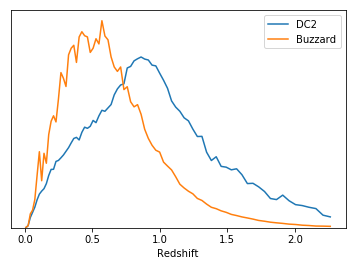

In [15]:
zc = 0.5 * (zds[1:] + zds[:-1])
plt.plot(zc, dndz_dc2, label='DC2')
plt.plot(zc, dndz_buz, label='Buzzard')
plt.xlabel('Redshift')
plt.yticks([])
plt.ylim(0, None)
plt.legend();

In [84]:
def optimize_direct(nbin, ntrial, nsteps, eta, transform, metric, method, seed, dndz_total=dndz_buz, init_data=init_data):
    mixing = jnp.diag(dndz_total)
    return optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=955.378 (max=955.378) after 375 steps.
  score=957.029 (max=957.029) after 750 steps.
  score=957.539 (max=957.539) after 1125 steps.
  score=957.742 (max=957.742) after 1500 steps.
trial 1/10: score=957.742 (max=957.742) after 1500 steps.
  score=955.202 (max=957.742) after 375 steps.
  score=956.868 (max=957.742) after 750 steps.
  score=957.369 (max=957.742) after 1125 steps.
  score=957.594 (max=957.742) after 1500 steps.
trial 2/10: score=957.594 (max=957.742) after 1500 steps.
  score=954.191 (max=957.742) after 375 steps.
  score=956.359 (max=957.742) after 750 steps.
  score=957.038 (max=957.742) after 1125 steps.
  score=957.350 (max=957.742) after 1500 steps.
trial 3/10: score=957.350 (max=957.742) after 1500 steps.
  score=955.291 (max=957.742) after 375 steps.
  score=957.353 (max=957.742) after 750 steps.
  score=958.043 

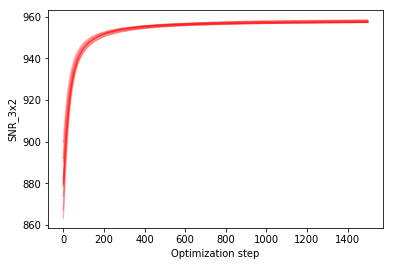

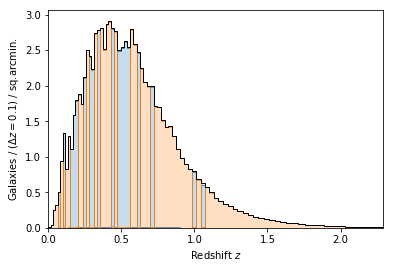

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1346.926 (max=1346.926) after 750 steps.
  score=1352.082 (max=1352.082) after 1500 steps.
  score=1353.684 (max=1353.684) after 2250 steps.
  score=1354.442 (max=1354.442) after 3000 steps.
trial 1/10: score=1354.442 (max=1354.442) after 3000 steps.
  score=1344.148 (max=1354.442) after 750 steps.
  score=1349.034 (max=1354.442) after 1500 steps.
  score=1350.328 (max=1354.442) after 2250 steps.
  score=1350.891 (max=1354.442) after 3000 steps.
trial 2/10: score=1350.891 (max=1354.442) after 3000 steps.
  score=1345.514 (max=1354.442) after 750 steps.
  score=1350.004 (max=1354.442) after 1500 steps.
  score=1351.198 (max=1354.442) after 2250 steps.
  score=1351.718 (max=1354.442) after 3000 steps.
trial 3/10: score=1351.718 (max=1354.442) after 3000 steps.
  score=1344.137 (max=1354.442) after 750 steps.
  score=1349.929 (max=1354.4

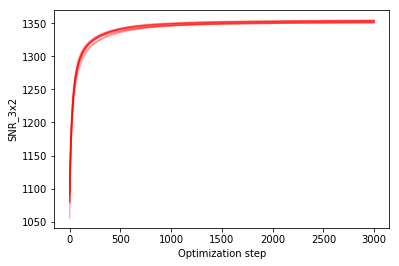

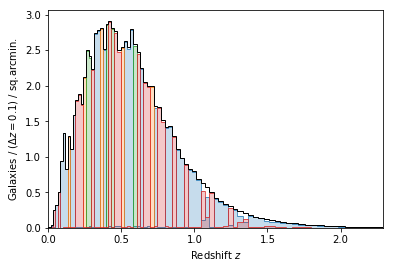

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1645.812 (max=1645.812) after 1125 steps.
  score=1652.883 (max=1652.883) after 2250 steps.
  score=1654.487 (max=1654.487) after 3375 steps.
  score=1655.104 (max=1655.104) after 4500 steps.
trial 1/10: score=1655.104 (max=1655.104) after 4500 steps.
  score=1647.855 (max=1655.104) after 1125 steps.
  score=1655.254 (max=1655.254) after 2250 steps.
  score=1657.029 (max=1657.029) after 3375 steps.
  score=1657.660 (max=1657.660) after 4500 steps.
trial 2/10: score=1657.660 (max=1657.660) after 4500 steps.
  score=1649.409 (max=1657.660) after 1125 steps.
  score=1655.465 (max=1657.660) after 2250 steps.
  score=1657.036 (max=1657.660) after 3375 steps.
  score=1657.723 (max=1657.723) after 4500 steps.
trial 3/10: score=1657.723 (max=1657.723) after 4500 steps.
  score=1650.620 (max=1657.723) after 1125 steps.
  score=1657.722 (max=16

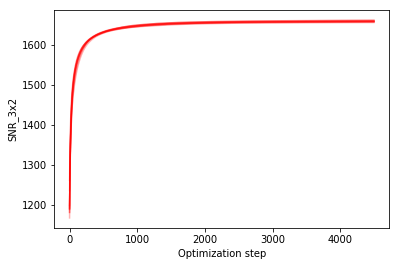

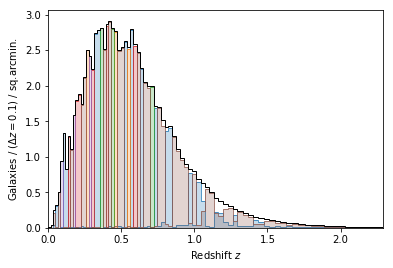

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1901.542 (max=1901.542) after 1500 steps.
  score=1908.733 (max=1908.733) after 3000 steps.
  score=1910.630 (max=1910.630) after 4500 steps.
  score=1911.375 (max=1911.375) after 6000 steps.
trial 1/10: score=1911.375 (max=1911.375) after 6000 steps.
  score=1905.131 (max=1911.375) after 1500 steps.
  score=1911.519 (max=1911.519) after 3000 steps.
  score=1913.373 (max=1913.373) after 4500 steps.
  score=1914.083 (max=1914.083) after 6000 steps.
trial 2/10: score=1914.083 (max=1914.083) after 6000 steps.
  score=1905.137 (max=1914.083) after 1500 steps.
  score=1913.101 (max=1914.083) after 3000 steps.
  score=1915.060 (max=1915.060) after 4500 steps.
  score=1915.775 (max=1915.775) after 6000 steps.
trial 3/10: score=1915.775 (max=1915.775) after 6000 steps.
  score=1908.236 (max=1915.775) after 1500 steps.
  score=1914.880 (max=19

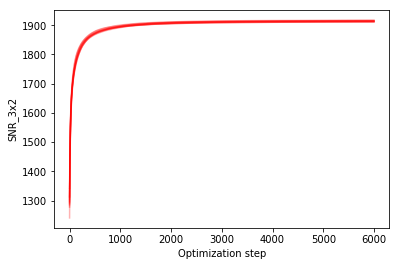

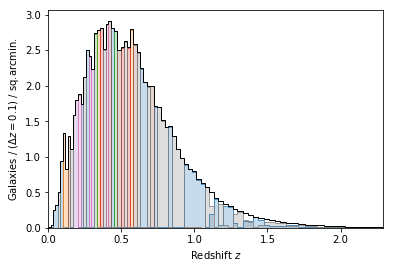

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=2130.203 (max=2130.203) after 1875 steps.
  score=2138.088 (max=2138.088) after 3750 steps.
  score=2140.043 (max=2140.043) after 5625 steps.
  score=2140.643 (max=2140.643) after 7500 steps.
trial 1/10: score=2140.643 (max=2140.643) after 7500 steps.
  score=2133.722 (max=2140.643) after 1875 steps.
  score=2140.645 (max=2140.645) after 3750 steps.
  score=2142.331 (max=2142.331) after 5625 steps.
  score=2142.973 (max=2142.974) after 7500 steps.
trial 2/10: score=2142.973 (max=2142.974) after 7500 steps.
  score=2130.392 (max=2142.974) after 1875 steps.
  score=2139.948 (max=2142.974) after 3750 steps.
  score=2141.925 (max=2142.974) after 5625 steps.
  score=2142.584 (max=2142.974) after 7500 steps.
trial 3/10: score=2142.584 (max=2142.974) after 7500 steps.
  score=2134.870 (max=2142.974) after 1875 steps.
  score=2144.475 (max=2

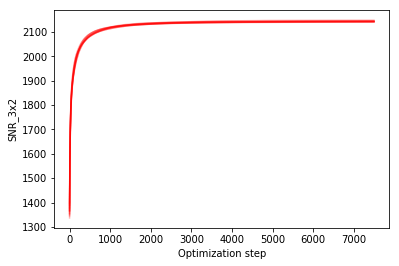

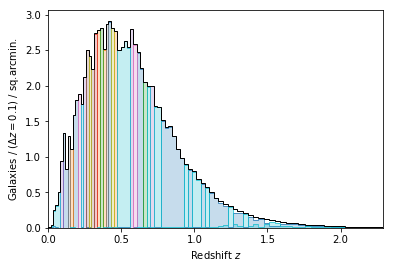

In [29]:
run_study('results/direct-snr', optimize_direct)

Starting job at 2020-09-11 07:39:50.061181 with {'nbin': 2, 'ntrial': 30, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=785.573 (max=785.573) after 375 steps.
  score=802.744 (max=802.777) after 750 steps.
  score=805.754 (max=805.840) after 1125 steps.
  score=860.870 (max=860.870) after 1500 steps.
trial 1/30: score=860.870 (max=860.870) after 1500 steps.
  score=1222.427 (max=1222.427) after 375 steps.
  score=1296.733 (max=1296.733) after 750 steps.
  score=1366.054 (max=1366.224) after 1125 steps.
  score=1370.092 (max=1370.180) after 1500 steps.
trial 2/30: score=1370.092 (max=1370.180) after 1500 steps.
  score=986.656 (max=1370.180) after 375 steps.
  score=1072.855 (max=1370.180) after 750 steps.
  score=1080.190 (max=1370.180) after 1125 steps.
  score=1082.124 (max=1370.180) after 1500 steps.
trial 3/30: score=1082.124 (max=1370.180) after 1500 steps.
  score=1186.232 (max=1370.180) after 375 steps.
  score=139

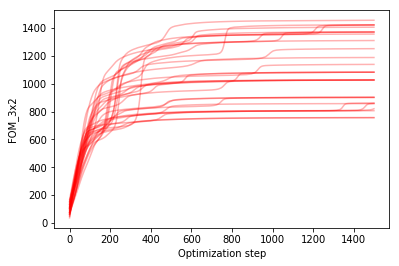

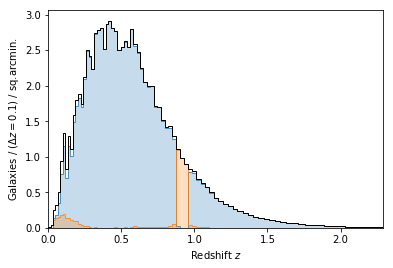

Starting job at 2020-09-11 07:43:24.414608 with {'nbin': 4, 'ntrial': 30, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=4092.447 (max=4092.581) after 750 steps.
  score=4141.213 (max=4141.213) after 1500 steps.
  score=4152.272 (max=4152.730) after 2250 steps.
  score=4159.733 (max=4159.733) after 3000 steps.
trial 1/30: score=4159.733 (max=4159.733) after 3000 steps.
  score=2909.396 (max=4159.733) after 750 steps.
  score=4151.574 (max=4159.733) after 1500 steps.
  score=4718.511 (max=4720.809) after 2250 steps.
  score=4814.121 (max=4817.002) after 3000 steps.
trial 2/30: score=4814.121 (max=4817.002) after 3000 steps.
  score=3322.678 (max=4817.002) after 750 steps.
  score=3474.808 (max=4817.002) after 1500 steps.
  score=3491.475 (max=4817.002) after 2250 steps.
  score=3506.474 (max=4817.002) after 3000 steps.
trial 3/30: score=3506.474 (max=4817.002) after 3000 steps.
  score=3330.750 (max=4817.002) after 750 step

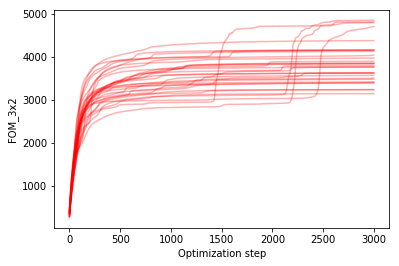

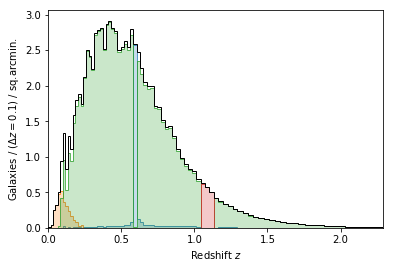

Starting job at 2020-09-11 07:55:55.747035 with {'nbin': 6, 'ntrial': 30, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=6031.228 (max=6031.774) after 1125 steps.
  score=6366.810 (max=6366.810) after 2250 steps.
  score=6419.987 (max=6419.987) after 3375 steps.
  score=6441.562 (max=6442.464) after 4500 steps.
trial 1/30: score=6441.562 (max=6442.464) after 4500 steps.
  score=5613.718 (max=6442.464) after 1125 steps.
  score=5660.061 (max=6442.464) after 2250 steps.
  score=5679.461 (max=6442.464) after 3375 steps.
  score=5693.398 (max=6442.464) after 4500 steps.
trial 2/30: score=5693.398 (max=6442.464) after 4500 steps.
  score=5132.622 (max=6442.464) after 1125 steps.
  score=5190.351 (max=6442.464) after 2250 steps.
  score=5211.823 (max=6442.464) after 3375 steps.
  score=5224.627 (max=6442.464) after 4500 steps.
trial 3/30: score=5224.627 (max=6442.464) after 4500 steps.
  score=5422.761 (max=6442.464) after 1125 

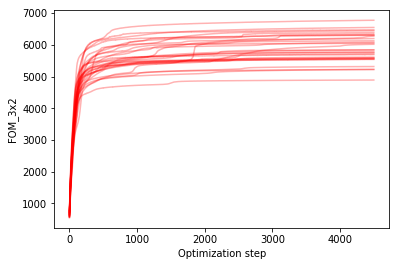

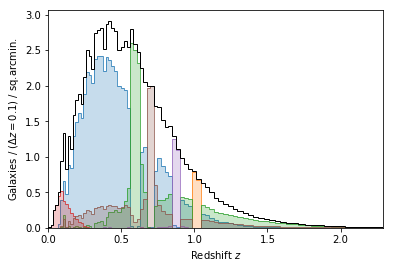

Starting job at 2020-09-11 08:36:02.863714 with {'nbin': 8, 'ntrial': 30, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=7976.170 (max=7977.152) after 1500 steps.
  score=8102.200 (max=8104.603) after 3000 steps.
  score=8141.352 (max=8143.631) after 4500 steps.
  score=8195.873 (max=8197.851) after 6000 steps.
trial 1/30: score=8195.873 (max=8197.851) after 6000 steps.
  score=7131.327 (max=8197.851) after 1500 steps.
  score=7248.479 (max=8197.851) after 3000 steps.
  score=7268.923 (max=8197.851) after 4500 steps.
  score=7281.827 (max=8197.851) after 6000 steps.
trial 2/30: score=7281.827 (max=8197.851) after 6000 steps.
  score=6543.470 (max=8197.851) after 1500 steps.
  score=6623.050 (max=8197.851) after 3000 steps.
  score=6740.058 (max=8197.851) after 4500 steps.
  score=6785.797 (max=8197.851) after 6000 steps.
trial 3/30: score=6785.797 (max=8197.851) after 6000 steps.
  score=7689.634 (max=8197.851) after 1500 

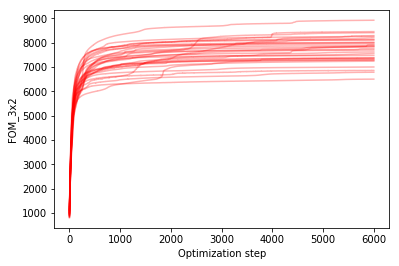

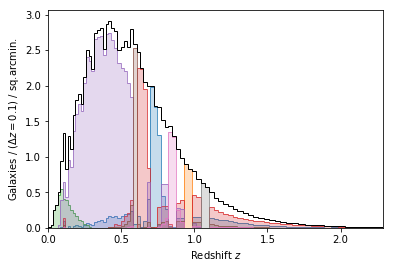

Starting job at 2020-09-11 09:44:52.398727 with {'nbin': 10, 'ntrial': 30, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=8969.775 (max=8969.775) after 1875 steps.
  score=9206.174 (max=9207.596) after 3750 steps.
  score=9250.040 (max=9251.841) after 5625 steps.
  score=9267.230 (max=9267.379) after 7500 steps.
trial 1/30: score=9267.230 (max=9267.379) after 7500 steps.
  score=8361.939 (max=9267.379) after 1875 steps.
  score=8606.490 (max=9267.379) after 3750 steps.
  score=8734.730 (max=9267.379) after 5625 steps.
  score=8877.967 (max=9267.379) after 7500 steps.
trial 2/30: score=8877.967 (max=9267.379) after 7500 steps.
  score=9220.113 (max=9267.379) after 1875 steps.
  score=9368.705 (max=9369.318) after 3750 steps.
  score=9455.747 (max=9457.301) after 5625 steps.
  score=9572.089 (max=9572.559) after 7500 steps.
trial 3/30: score=9572.089 (max=9572.559) after 7500 steps.
  score=8231.487 (max=9572.559) after 1875

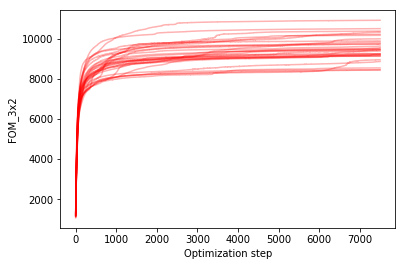

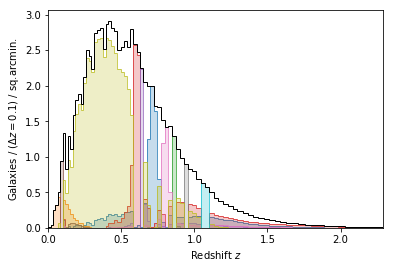

In [87]:
run_study('results/direct-fom', optimize_direct, rerun='all')

Running job with {'nbin': 2, 'ntrial': 10, 'nsteps': 1000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=20.918 (max=20.918) after 250 steps.
  score=22.061 (max=22.061) after 500 steps.
  score=22.402 (max=22.402) after 750 steps.
  score=22.520 (max=22.521) after 1000 steps.
trial 1/10: score=22.520 (max=22.521) after 1000 steps.
  score=20.319 (max=22.521) after 250 steps.
  score=21.783 (max=22.521) after 500 steps.
  score=22.253 (max=22.521) after 750 steps.
  score=22.438 (max=22.521) after 1000 steps.
trial 2/10: score=22.438 (max=22.521) after 1000 steps.
  score=20.495 (max=22.521) after 250 steps.
  score=21.868 (max=22.521) after 500 steps.
  score=22.299 (max=22.521) after 750 steps.
  score=22.461 (max=22.521) after 1000 steps.
trial 3/10: score=22.461 (max=22.521) after 1000 steps.
  score=20.717 (max=22.521) after 250 steps.
  score=21.977 (max=22.521) after 500 steps.
  score=22.341 (max=22.521) after 750 steps.
  score=22.495 (

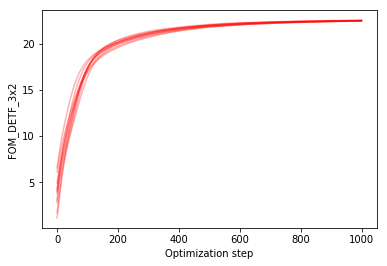

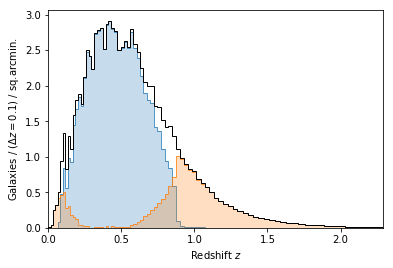

Running job with {'nbin': 4, 'ntrial': 10, 'nsteps': 2000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.099 (max=63.099) after 500 steps.
  score=65.469 (max=65.481) after 1000 steps.
  score=66.134 (max=66.148) after 1500 steps.
  score=66.466 (max=66.474) after 2000 steps.
trial 1/10: score=66.466 (max=66.474) after 2000 steps.
  score=62.059 (max=66.474) after 500 steps.
  score=65.678 (max=66.474) after 1000 steps.
  score=66.659 (max=66.659) after 1500 steps.
  score=67.088 (max=67.091) after 2000 steps.
trial 2/10: score=67.088 (max=67.091) after 2000 steps.
  score=49.022 (max=67.091) after 500 steps.
  score=65.316 (max=67.091) after 1000 steps.
  score=66.622 (max=67.091) after 1500 steps.
  score=66.898 (max=67.091) after 2000 steps.
trial 3/10: score=66.898 (max=67.091) after 2000 steps.
  score=64.013 (max=67.091) after 500 steps.
  score=66.073 (max=67.091) after 1000 steps.
  score=66.664 (max=67.091) after 1500 steps.
  score=

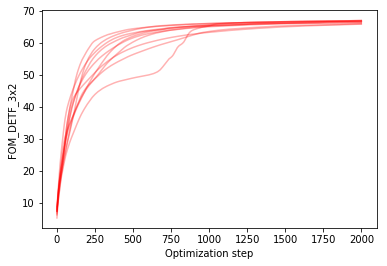

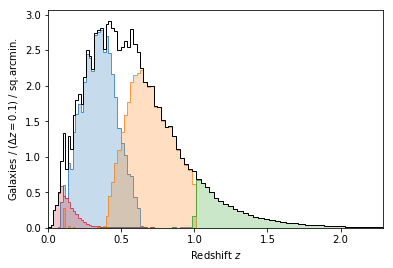

Running job with {'nbin': 6, 'ntrial': 10, 'nsteps': 3000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=84.664 (max=84.664) after 750 steps.
  score=86.687 (max=86.713) after 1500 steps.
  score=87.530 (max=87.550) after 2250 steps.
  score=87.957 (max=87.963) after 3000 steps.
trial 1/10: score=87.957 (max=87.963) after 3000 steps.
  score=81.241 (max=87.963) after 750 steps.
  score=84.082 (max=87.963) after 1500 steps.
  score=85.000 (max=87.963) after 2250 steps.
  score=85.487 (max=87.963) after 3000 steps.
trial 2/10: score=85.487 (max=87.963) after 3000 steps.
  score=80.212 (max=87.963) after 750 steps.
  score=83.715 (max=87.963) after 1500 steps.
  score=85.108 (max=87.963) after 2250 steps.
  score=85.754 (max=87.963) after 3000 steps.
trial 3/10: score=85.754 (max=87.963) after 3000 steps.
  score=83.268 (max=87.963) after 750 steps.
  score=86.281 (max=87.963) after 1500 steps.
  score=87.456 (max=87.963) after 2250 steps.
  score=

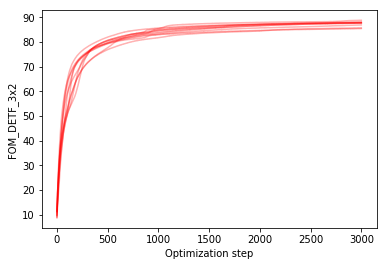

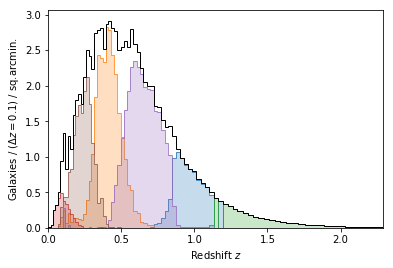

Running job with {'nbin': 8, 'ntrial': 10, 'nsteps': 4000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=97.727 (max=97.765) after 1000 steps.
  score=103.029 (max=103.062) after 2000 steps.
  score=104.074 (max=104.074) after 3000 steps.
  score=104.835 (max=104.858) after 4000 steps.
trial 1/10: score=104.835 (max=104.858) after 4000 steps.
  score=96.247 (max=104.858) after 1000 steps.
  score=100.355 (max=104.858) after 2000 steps.
  score=102.420 (max=104.858) after 3000 steps.
  score=103.161 (max=104.858) after 4000 steps.
trial 2/10: score=103.161 (max=104.858) after 4000 steps.
  score=93.226 (max=104.858) after 1000 steps.
  score=98.151 (max=104.858) after 2000 steps.
  score=100.458 (max=104.858) after 3000 steps.
  score=102.285 (max=104.858) after 4000 steps.
trial 3/10: score=102.285 (max=104.858) after 4000 steps.
  score=95.660 (max=104.858) after 1000 steps.
  score=99.745 (max=104.858) after 2000 steps.
  score=101.735 (max=10

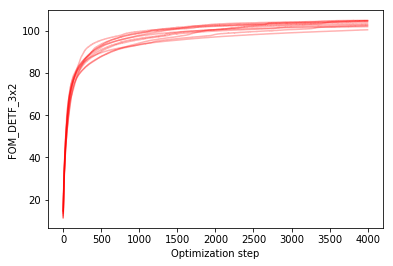

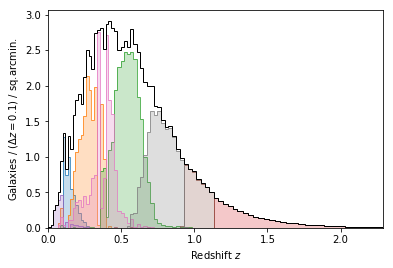

Running job with {'nbin': 10, 'ntrial': 10, 'nsteps': 5000, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=109.943 (max=109.943) after 1250 steps.
  score=116.768 (max=116.769) after 2500 steps.
  score=119.791 (max=119.804) after 3750 steps.
  score=121.621 (max=121.629) after 5000 steps.
trial 1/10: score=121.621 (max=121.629) after 5000 steps.
  score=112.180 (max=121.629) after 1250 steps.
  score=115.792 (max=121.629) after 2500 steps.
  score=118.124 (max=121.629) after 3750 steps.
  score=119.421 (max=121.629) after 5000 steps.
trial 2/10: score=119.421 (max=121.629) after 5000 steps.
  score=111.035 (max=121.629) after 1250 steps.
  score=115.830 (max=121.629) after 2500 steps.
  score=117.339 (max=121.629) after 3750 steps.
  score=118.810 (max=121.629) after 5000 steps.
trial 3/10: score=118.810 (max=121.629) after 5000 steps.
  score=111.987 (max=121.629) after 1250 steps.
  score=117.426 (max=121.629) after 2500 steps.
  score=119.242

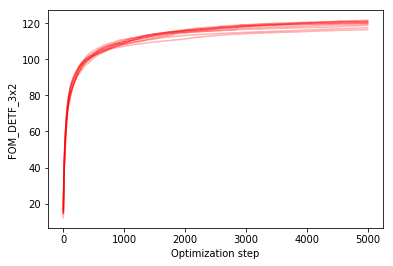

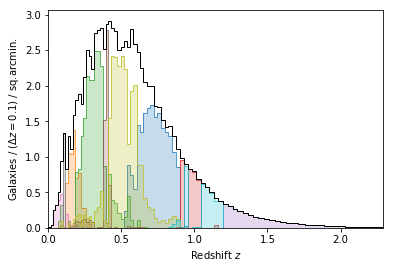

In [21]:
run_study('results/direct-detf', optimize_direct)

## Optimize redshift bins using features

In [33]:
def optimize_bins(nbin, groups, ntrial, nsteps, eta, transform, metric, method, seed, init_data=init_data):
    _, _, _, zhist, _ = load_groups(groups + '.npz')
    ngrp, nzin = zhist.shape
    nzout = len(init_data[0]) - 1
    assert nzin % nzout == 0
    downsampling = nzin // nzout
    if downsampling > 1:
        print(f'Downsampling by {downsampling}.')
        zhist = zhist.reshape(ngrp, nzout, downsampling).sum(axis=-1)
    mixing = jnp.array(zhist / zhist.sum())
    return optimize(
        nbin, mixing, init_data, ntrial=ntrial, interval=nsteps // 4,
        transform=transform, method=method, metric=metric,
        opt_args=dict(optimizer=optimizers.adam(eta), nsteps=nsteps))

Running job with {'groups': 'group_emd_80_300', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.752 (max=18.752) after 375 steps.
  score=19.682 (max=19.682) after 750 steps.
  score=20.034 (max=20.035) after 1125 steps.
  score=20.168 (max=20.169) after 1500 steps.
trial 1/10: score=20.168 (max=20.169) after 1500 steps.
  score=18.649 (max=20.169) after 375 steps.
  score=19.624 (max=20.169) after 750 steps.
  score=20.020 (max=20.169) after 1125 steps.
  score=20.167 (max=20.169) after 1500 steps.
trial 2/10: score=20.167 (max=20.169) after 1500 steps.
  score=18.570 (max=20.169) after 375 steps.
  score=19.670 (max=20.169) after 750 steps.
  score=20.039 (max=20.169) after 1125 steps.
  score=20.166 (max=20.169) after 1500 steps.
trial 3/10: score=20.166 (max=20.169) after 1500 steps.
  score=18.571 (max=20.169) after 375 steps.
  score=19.585 (max=20.169) after 750 steps.
  score=19.943 

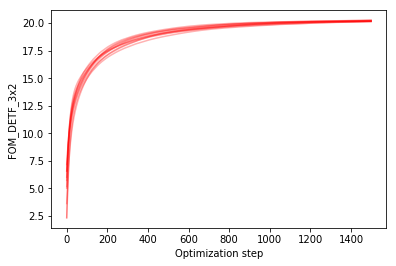

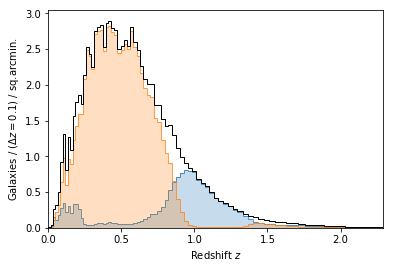

Running job with {'groups': 'group_emd_80_300', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=52.925 (max=52.925) after 750 steps.
  score=54.055 (max=54.057) after 1500 steps.
  score=54.387 (max=54.392) after 2250 steps.
  score=54.553 (max=54.554) after 3000 steps.
trial 1/10: score=54.553 (max=54.554) after 3000 steps.
  score=52.212 (max=54.554) after 750 steps.
  score=54.348 (max=54.554) after 1500 steps.
  score=54.758 (max=54.759) after 2250 steps.
  score=54.866 (max=54.866) after 3000 steps.
trial 2/10: score=54.866 (max=54.866) after 3000 steps.
  score=50.931 (max=54.866) after 750 steps.
  score=53.400 (max=54.866) after 1500 steps.
  score=54.073 (max=54.866) after 2250 steps.
  score=54.403 (max=54.866) after 3000 steps.
trial 3/10: score=54.403 (max=54.866) after 3000 steps.
  score=50.820 (max=54.866) after 750 steps.
  score=53.177 (max=54.866) after 1500 steps.
  score=54.

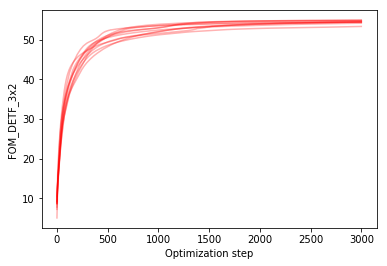

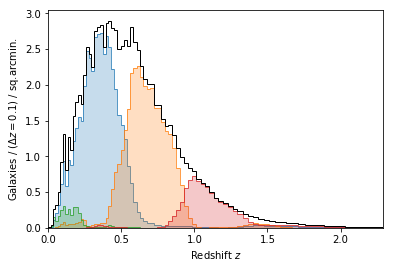

Running job with {'groups': 'group_emd_80_300', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=63.730 (max=63.750) after 1125 steps.
  score=66.081 (max=66.102) after 2250 steps.
  score=67.348 (max=67.348) after 3375 steps.
  score=68.057 (max=68.063) after 4500 steps.
trial 1/10: score=68.057 (max=68.063) after 4500 steps.
  score=64.464 (max=68.063) after 1125 steps.
  score=65.891 (max=68.063) after 2250 steps.
  score=66.519 (max=68.063) after 3375 steps.
  score=66.958 (max=68.063) after 4500 steps.
trial 2/10: score=66.958 (max=68.063) after 4500 steps.
  score=64.454 (max=68.063) after 1125 steps.
  score=66.114 (max=68.063) after 2250 steps.
  score=66.896 (max=68.063) after 3375 steps.
  score=67.387 (max=68.063) after 4500 steps.
trial 3/10: score=67.387 (max=68.063) after 4500 steps.
  score=64.627 (max=68.063) after 1125 steps.
  score=66.486 (max=68.063) after 2250 steps.
  score

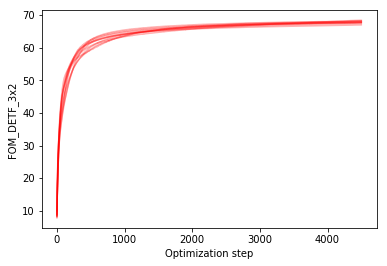

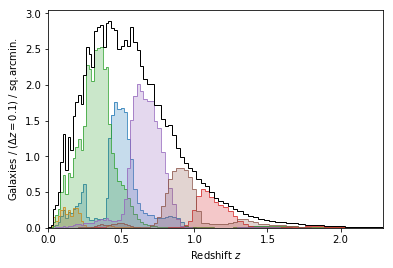

Running job with {'groups': 'group_emd_80_300', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.710 (max=71.710) after 1500 steps.
  score=74.673 (max=74.677) after 3000 steps.
  score=76.120 (max=76.138) after 4500 steps.
  score=76.729 (max=76.729) after 6000 steps.
trial 1/10: score=76.729 (max=76.729) after 6000 steps.
  score=74.573 (max=76.729) after 1500 steps.
  score=77.402 (max=77.409) after 3000 steps.
  score=78.391 (max=78.394) after 4500 steps.
  score=78.841 (max=78.843) after 6000 steps.
trial 2/10: score=78.841 (max=78.843) after 6000 steps.
  score=75.480 (max=78.843) after 1500 steps.
  score=77.484 (max=78.843) after 3000 steps.
  score=78.221 (max=78.843) after 4500 steps.
  score=78.680 (max=78.843) after 6000 steps.
trial 3/10: score=78.680 (max=78.843) after 6000 steps.
  score=73.366 (max=78.843) after 1500 steps.
  score=75.275 (max=78.843) after 3000 steps.
  score

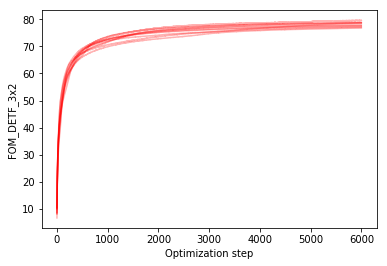

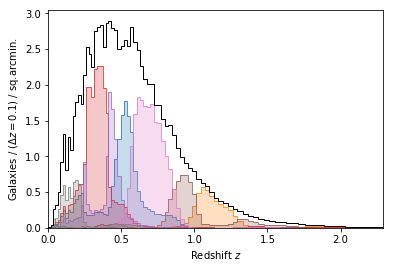

Running job with {'groups': 'group_emd_80_300', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.101 (max=81.120) after 1875 steps.
  score=85.266 (max=85.266) after 3750 steps.
  score=86.467 (max=86.471) after 5625 steps.
  score=87.029 (max=87.038) after 7500 steps.
trial 1/10: score=87.029 (max=87.038) after 7500 steps.
  score=81.465 (max=87.038) after 1875 steps.
  score=84.560 (max=87.038) after 3750 steps.
  score=86.085 (max=87.038) after 5625 steps.
  score=86.781 (max=87.038) after 7500 steps.
trial 2/10: score=86.781 (max=87.038) after 7500 steps.
  score=81.607 (max=87.038) after 1875 steps.
  score=84.219 (max=87.038) after 3750 steps.
  score=85.604 (max=87.038) after 5625 steps.
  score=86.362 (max=87.038) after 7500 steps.
trial 3/10: score=86.362 (max=87.038) after 7500 steps.
  score=79.166 (max=87.038) after 1875 steps.
  score=82.730 (max=87.038) after 3750 steps.
  scor

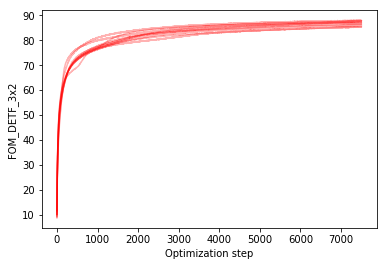

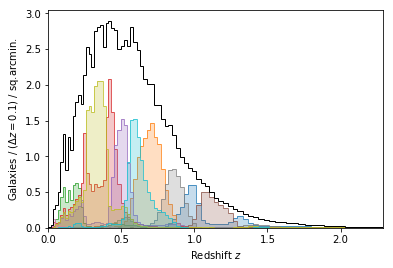

In [38]:
run_study('results/edm-300-detf', optimize_bins)

Running job with {'groups': 'group_emd_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.912 (max=18.912) after 375 steps.
  score=19.846 (max=19.846) after 750 steps.
  score=20.112 (max=20.112) after 1125 steps.
  score=20.240 (max=20.241) after 1500 steps.
trial 1/10: score=20.240 (max=20.241) after 1500 steps.
  score=18.660 (max=20.241) after 375 steps.
  score=19.697 (max=20.241) after 750 steps.
  score=20.038 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 2/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.688 (max=20.241) after 375 steps.
  score=19.695 (max=20.241) after 750 steps.
  score=20.051 (max=20.241) after 1125 steps.
  score=20.170 (max=20.241) after 1500 steps.
trial 3/10: score=20.170 (max=20.241) after 1500 steps.
  score=18.411 (max=20.241) after 375 steps.
  score=19.536 (max=20.241) after 750 steps.
  score=19.980 

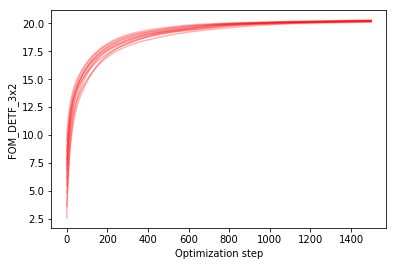

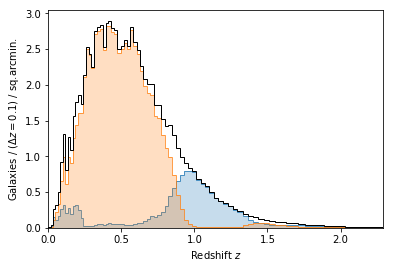

Running job with {'groups': 'group_emd_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=49.656 (max=49.657) after 750 steps.
  score=51.712 (max=51.712) after 1500 steps.
  score=52.510 (max=52.513) after 2250 steps.
  score=53.238 (max=53.240) after 3000 steps.
trial 1/10: score=53.238 (max=53.240) after 3000 steps.
  score=52.426 (max=53.240) after 750 steps.
  score=53.688 (max=53.696) after 1500 steps.
  score=54.145 (max=54.147) after 2250 steps.
  score=54.365 (max=54.367) after 3000 steps.
trial 2/10: score=54.365 (max=54.367) after 3000 steps.
  score=49.246 (max=54.367) after 750 steps.
  score=51.540 (max=54.367) after 1500 steps.
  score=52.777 (max=54.367) after 2250 steps.
  score=54.332 (max=54.367) after 3000 steps.
trial 3/10: score=54.332 (max=54.367) after 3000 steps.
  score=51.126 (max=54.367) after 750 steps.
  score=53.829 (max=54.367) after 1500 steps.
  score=54.

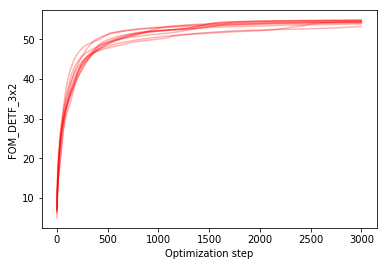

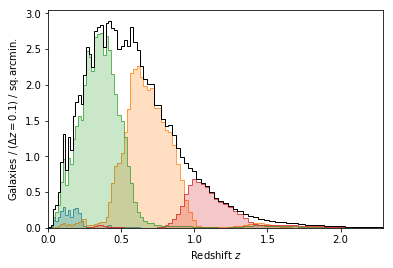

Running job with {'groups': 'group_emd_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=65.338 (max=65.345) after 1125 steps.
  score=66.816 (max=66.816) after 2250 steps.
  score=67.453 (max=67.453) after 3375 steps.
  score=67.781 (max=67.798) after 4500 steps.
trial 1/10: score=67.781 (max=67.798) after 4500 steps.
  score=65.428 (max=67.798) after 1125 steps.
  score=66.856 (max=67.798) after 2250 steps.
  score=67.475 (max=67.798) after 3375 steps.
  score=67.871 (max=67.877) after 4500 steps.
trial 2/10: score=67.871 (max=67.877) after 4500 steps.
  score=65.787 (max=67.877) after 1125 steps.
  score=67.421 (max=67.877) after 2250 steps.
  score=67.858 (max=67.882) after 3375 steps.
  score=68.245 (max=68.257) after 4500 steps.
trial 3/10: score=68.245 (max=68.257) after 4500 steps.
  score=64.001 (max=68.257) after 1125 steps.
  score=66.737 (max=68.257) after 2250 steps.
  score

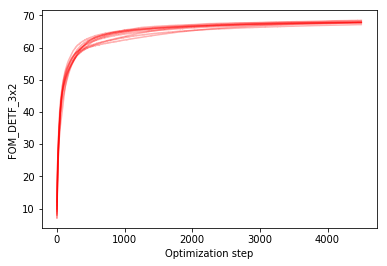

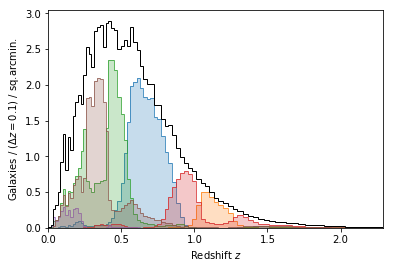

Running job with {'groups': 'group_emd_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.000 (max=71.053) after 1500 steps.
  score=73.854 (max=73.865) after 3000 steps.
  score=75.633 (max=75.649) after 4500 steps.
  score=76.310 (max=76.352) after 6000 steps.
trial 1/10: score=76.310 (max=76.352) after 6000 steps.
  score=75.798 (max=76.352) after 1500 steps.
  score=77.366 (max=77.458) after 3000 steps.
  score=77.988 (max=78.132) after 4500 steps.
  score=78.784 (max=78.993) after 6000 steps.
trial 2/10: score=78.784 (max=78.993) after 6000 steps.
  score=73.588 (max=78.993) after 1500 steps.
  score=76.105 (max=78.993) after 3000 steps.
  score=76.865 (max=78.993) after 4500 steps.
  score=77.243 (max=78.993) after 6000 steps.
trial 3/10: score=77.243 (max=78.993) after 6000 steps.
  score=75.180 (max=78.993) after 1500 steps.
  score=77.113 (max=78.993) after 3000 steps.
  score

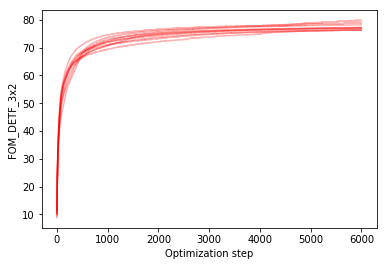

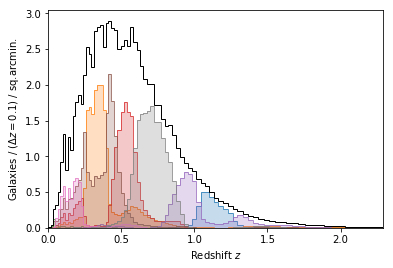

Running job with {'groups': 'group_emd_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=80.462 (max=80.642) after 1875 steps.
  score=83.813 (max=84.048) after 3750 steps.
  score=85.579 (max=85.579) after 5625 steps.
  score=86.167 (max=86.279) after 7500 steps.
trial 1/10: score=86.167 (max=86.279) after 7500 steps.
  score=81.119 (max=86.279) after 1875 steps.
  score=83.277 (max=86.279) after 3750 steps.
  score=84.266 (max=86.279) after 5625 steps.
  score=84.842 (max=86.279) after 7500 steps.
trial 2/10: score=84.842 (max=86.279) after 7500 steps.
  score=79.266 (max=86.279) after 1875 steps.
  score=80.829 (max=86.279) after 3750 steps.
  score=82.854 (max=86.279) after 5625 steps.
  score=85.485 (max=86.279) after 7500 steps.
trial 3/10: score=85.485 (max=86.279) after 7500 steps.
  score=83.282 (max=86.279) after 1875 steps.
  score=85.747 (max=86.279) after 3750 steps.
  scor

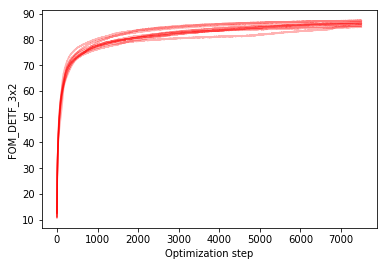

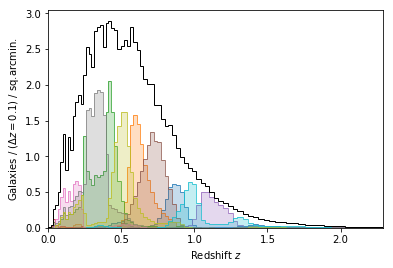

In [39]:
run_study('results/edm-150-detf', optimize_bins)

Running job with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.403 (max=18.403) after 375 steps.
  score=19.646 (max=19.646) after 750 steps.
  score=20.063 (max=20.063) after 1125 steps.
  score=20.204 (max=20.205) after 1500 steps.
trial 1/10: score=20.204 (max=20.205) after 1500 steps.
  score=18.906 (max=20.205) after 375 steps.
  score=19.828 (max=20.205) after 750 steps.
  score=20.141 (max=20.205) after 1125 steps.
  score=20.235 (max=20.237) after 1500 steps.
trial 2/10: score=20.235 (max=20.237) after 1500 steps.
  score=19.090 (max=20.237) after 375 steps.
  score=20.009 (max=20.237) after 750 steps.
  score=20.207 (max=20.237) after 1125 steps.
  score=20.276 (max=20.278) after 1500 steps.
trial 3/10: score=20.276 (max=20.278) after 1500 steps.
  score=18.993 (max=20.278) after 375 steps.
  score=19.902 (max=20.278) after 750 steps.
  score=20.167 

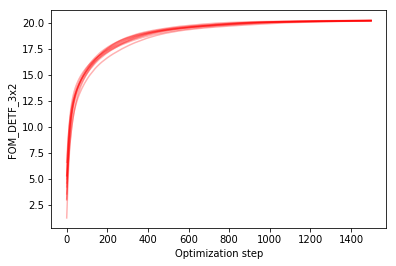

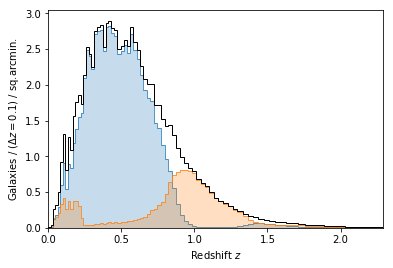

Running job with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=53.153 (max=53.153) after 750 steps.
  score=54.100 (max=54.100) after 1500 steps.
  score=54.398 (max=54.398) after 2250 steps.
  score=54.568 (max=54.574) after 3000 steps.
trial 1/10: score=54.568 (max=54.574) after 3000 steps.
  score=51.993 (max=54.574) after 750 steps.
  score=53.623 (max=54.574) after 1500 steps.
  score=54.124 (max=54.574) after 2250 steps.
  score=54.363 (max=54.574) after 3000 steps.
trial 2/10: score=54.363 (max=54.574) after 3000 steps.
  score=49.755 (max=54.574) after 750 steps.
  score=52.235 (max=54.574) after 1500 steps.
  score=54.183 (max=54.574) after 2250 steps.
  score=54.602 (max=54.603) after 3000 steps.
trial 3/10: score=54.602 (max=54.603) after 3000 steps.
  score=49.422 (max=54.603) after 750 steps.
  score=52.000 (max=54.603) after 1500 steps.
  score=54.

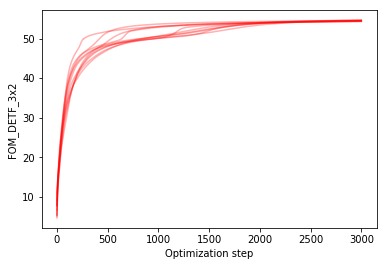

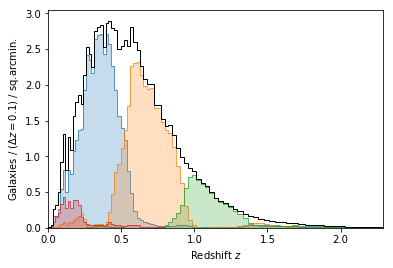

Running job with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=66.275 (max=66.275) after 1125 steps.
  score=67.699 (max=67.704) after 2250 steps.
  score=68.461 (max=68.465) after 3375 steps.
  score=69.040 (max=69.040) after 4500 steps.
trial 1/10: score=69.040 (max=69.040) after 4500 steps.
  score=66.566 (max=69.040) after 1125 steps.
  score=68.104 (max=69.040) after 2250 steps.
  score=68.605 (max=69.040) after 3375 steps.
  score=68.992 (max=69.040) after 4500 steps.
trial 2/10: score=68.992 (max=69.040) after 4500 steps.
  score=64.093 (max=69.040) after 1125 steps.
  score=66.990 (max=69.040) after 2250 steps.
  score=67.988 (max=69.040) after 3375 steps.
  score=68.420 (max=69.040) after 4500 steps.
trial 3/10: score=68.420 (max=69.040) after 4500 steps.
  score=62.498 (max=69.040) after 1125 steps.
  score=65.671 (max=69.040) after 2250 steps.
  score

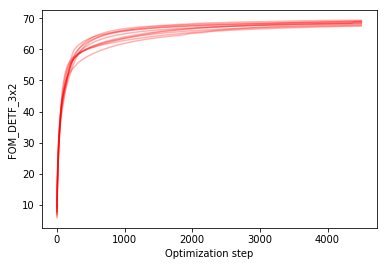

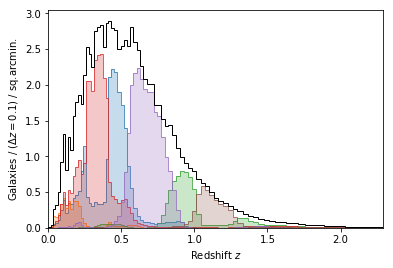

Running job with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=72.935 (max=72.935) after 1500 steps.
  score=75.879 (max=75.891) after 3000 steps.
  score=76.783 (max=76.800) after 4500 steps.
  score=77.156 (max=77.156) after 6000 steps.
trial 1/10: score=77.156 (max=77.156) after 6000 steps.
  score=73.506 (max=77.156) after 1500 steps.
  score=76.039 (max=77.156) after 3000 steps.
  score=76.799 (max=77.156) after 4500 steps.
  score=77.150 (max=77.156) after 6000 steps.
trial 2/10: score=77.150 (max=77.156) after 6000 steps.
  score=73.964 (max=77.156) after 1500 steps.
  score=75.997 (max=77.156) after 3000 steps.
  score=76.706 (max=77.156) after 4500 steps.
  score=77.112 (max=77.156) after 6000 steps.
trial 3/10: score=77.112 (max=77.156) after 6000 steps.
  score=73.583 (max=77.156) after 1500 steps.
  score=75.962 (max=77.156) after 3000 steps.
  score

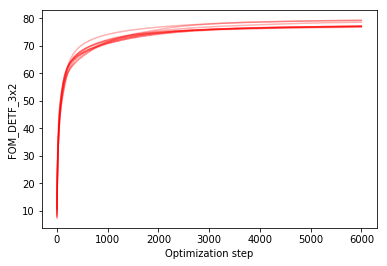

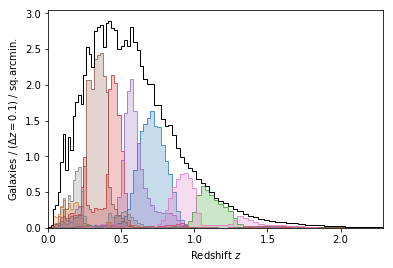

Running job with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=82.099 (max=82.110) after 1875 steps.
  score=85.686 (max=85.687) after 3750 steps.
  score=86.912 (max=86.939) after 5625 steps.
  score=87.603 (max=87.616) after 7500 steps.
trial 1/10: score=87.603 (max=87.616) after 7500 steps.
  score=80.419 (max=87.616) after 1875 steps.
  score=83.552 (max=87.616) after 3750 steps.
  score=84.997 (max=87.616) after 5625 steps.
  score=85.776 (max=87.616) after 7500 steps.
trial 2/10: score=85.776 (max=87.616) after 7500 steps.
  score=84.511 (max=87.616) after 1875 steps.
  score=87.257 (max=87.616) after 3750 steps.
  score=88.005 (max=88.010) after 5625 steps.
  score=88.353 (max=88.353) after 7500 steps.
trial 3/10: score=88.353 (max=88.353) after 7500 steps.
  score=84.285 (max=88.353) after 1875 steps.
  score=86.874 (max=88.353) after 3750 steps.
  scor

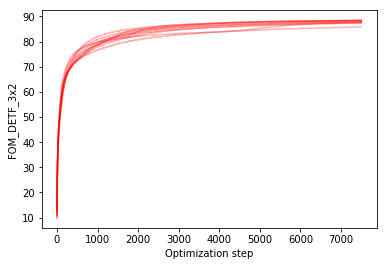

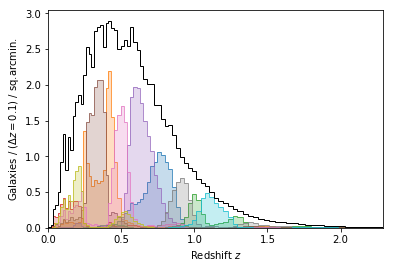

In [40]:
run_study('results/cos-150-detf', optimize_bins)

Running job with {'groups': 'group_wgt_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.402 (max=18.402) after 375 steps.
  score=19.546 (max=19.546) after 750 steps.
  score=19.872 (max=19.874) after 1125 steps.
  score=20.003 (max=20.003) after 1500 steps.
trial 1/10: score=20.003 (max=20.003) after 1500 steps.
  score=18.531 (max=20.003) after 375 steps.
  score=19.533 (max=20.003) after 750 steps.
  score=19.868 (max=20.003) after 1125 steps.
  score=20.011 (max=20.012) after 1500 steps.
trial 2/10: score=20.011 (max=20.012) after 1500 steps.
  score=18.505 (max=20.012) after 375 steps.
  score=19.521 (max=20.012) after 750 steps.
  score=19.878 (max=20.012) after 1125 steps.
  score=20.002 (max=20.012) after 1500 steps.
trial 3/10: score=20.002 (max=20.012) after 1500 steps.
  score=19.064 (max=20.012) after 375 steps.
  score=19.803 (max=20.012) after 750 steps.
  score=20.013 

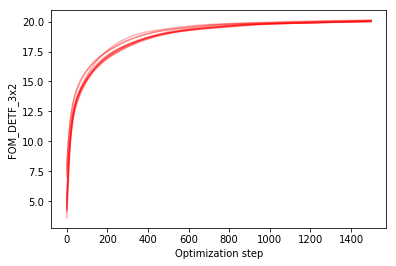

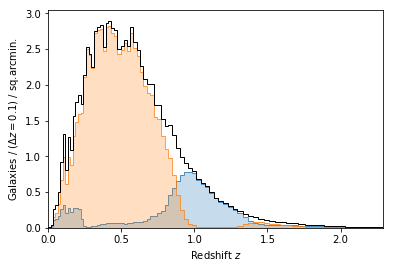

Running job with {'groups': 'group_wgt_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=48.263 (max=48.263) after 750 steps.
  score=49.613 (max=49.613) after 1500 steps.
  score=50.279 (max=50.286) after 2250 steps.
  score=50.870 (max=50.870) after 3000 steps.
trial 1/10: score=50.870 (max=50.870) after 3000 steps.
  score=52.572 (max=52.584) after 750 steps.
  score=53.276 (max=53.294) after 1500 steps.
  score=53.569 (max=53.571) after 2250 steps.
  score=53.723 (max=53.738) after 3000 steps.
trial 2/10: score=53.723 (max=53.738) after 3000 steps.
  score=49.665 (max=53.738) after 750 steps.
  score=53.589 (max=53.738) after 1500 steps.
  score=54.008 (max=54.009) after 2250 steps.
  score=54.114 (max=54.116) after 3000 steps.
trial 3/10: score=54.114 (max=54.116) after 3000 steps.
  score=51.828 (max=54.116) after 750 steps.
  score=53.835 (max=54.116) after 1500 steps.
  score=54.

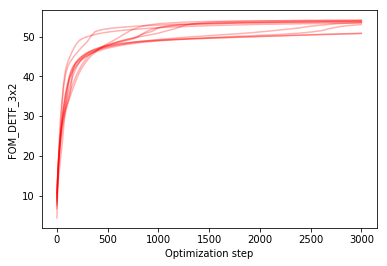

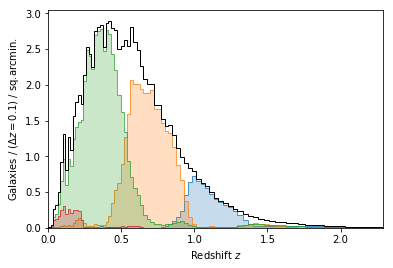

Running job with {'groups': 'group_wgt_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=65.049 (max=65.049) after 1125 steps.
  score=66.773 (max=66.786) after 2250 steps.
  score=67.351 (max=67.356) after 3375 steps.
  score=67.618 (max=67.634) after 4500 steps.
trial 1/10: score=67.618 (max=67.634) after 4500 steps.
  score=64.364 (max=67.634) after 1125 steps.
  score=66.429 (max=67.634) after 2250 steps.
  score=67.114 (max=67.634) after 3375 steps.
  score=67.431 (max=67.634) after 4500 steps.
trial 2/10: score=67.431 (max=67.634) after 4500 steps.
  score=61.874 (max=67.634) after 1125 steps.
  score=64.269 (max=67.634) after 2250 steps.
  score=65.736 (max=67.634) after 3375 steps.
  score=66.597 (max=67.634) after 4500 steps.
trial 3/10: score=66.597 (max=67.634) after 4500 steps.
  score=64.591 (max=67.634) after 1125 steps.
  score=66.221 (max=67.634) after 2250 steps.
  score

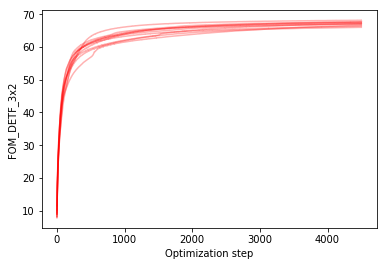

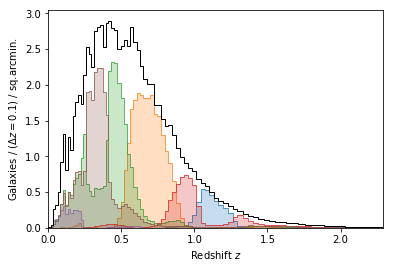

Running job with {'groups': 'group_wgt_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=71.722 (max=71.722) after 1500 steps.
  score=73.336 (max=73.344) after 3000 steps.
  score=74.072 (max=74.111) after 4500 steps.
  score=74.589 (max=74.589) after 6000 steps.
trial 1/10: score=74.589 (max=74.589) after 6000 steps.
  score=73.902 (max=74.589) after 1500 steps.
  score=76.348 (max=76.368) after 3000 steps.
  score=77.171 (max=77.194) after 4500 steps.
  score=77.599 (max=77.613) after 6000 steps.
trial 2/10: score=77.599 (max=77.613) after 6000 steps.
  score=72.856 (max=77.613) after 1500 steps.
  score=74.885 (max=77.613) after 3000 steps.
  score=75.585 (max=77.613) after 4500 steps.
  score=76.051 (max=77.613) after 6000 steps.
trial 3/10: score=76.051 (max=77.613) after 6000 steps.
  score=72.313 (max=77.613) after 1500 steps.
  score=73.915 (max=77.613) after 3000 steps.
  score

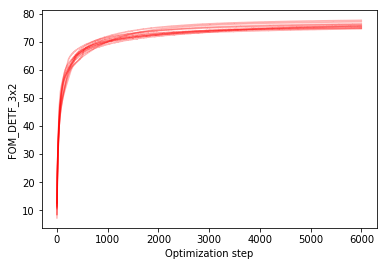

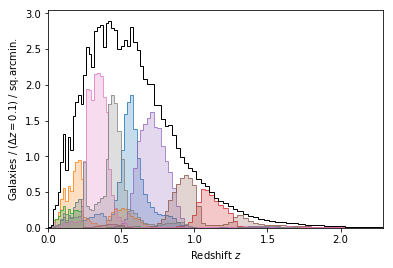

Running job with {'groups': 'group_wgt_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=81.996 (max=82.047) after 1875 steps.
  score=84.960 (max=85.005) after 3750 steps.
  score=85.917 (max=85.922) after 5625 steps.
  score=86.372 (max=86.394) after 7500 steps.
trial 1/10: score=86.372 (max=86.394) after 7500 steps.
  score=80.694 (max=86.394) after 1875 steps.
  score=83.228 (max=86.394) after 3750 steps.
  score=84.197 (max=86.394) after 5625 steps.
  score=85.024 (max=86.394) after 7500 steps.
trial 2/10: score=85.024 (max=86.394) after 7500 steps.
  score=82.485 (max=86.394) after 1875 steps.
  score=85.197 (max=86.394) after 3750 steps.
  score=86.047 (max=86.394) after 5625 steps.
  score=86.446 (max=86.464) after 7500 steps.
trial 3/10: score=86.446 (max=86.464) after 7500 steps.
  score=78.802 (max=86.464) after 1875 steps.
  score=82.465 (max=86.464) after 3750 steps.
  scor

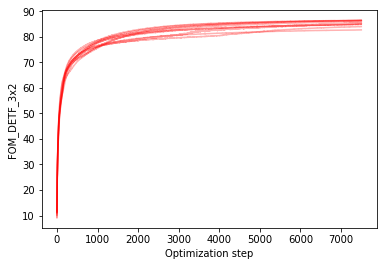

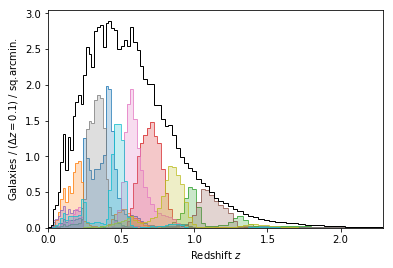

In [41]:
run_study('results/wgt-150-detf', optimize_bins)

Running job with {'groups': 'group_cos_80_75', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=18.837 (max=18.837) after 375 steps.
  score=19.904 (max=19.904) after 750 steps.
  score=20.125 (max=20.126) after 1125 steps.
  score=20.206 (max=20.206) after 1500 steps.
trial 1/10: score=20.206 (max=20.206) after 1500 steps.
  score=18.540 (max=20.206) after 375 steps.
  score=19.696 (max=20.206) after 750 steps.
  score=20.059 (max=20.206) after 1125 steps.
  score=20.158 (max=20.206) after 1500 steps.
trial 2/10: score=20.158 (max=20.206) after 1500 steps.
  score=18.595 (max=20.206) after 375 steps.
  score=19.793 (max=20.206) after 750 steps.
  score=20.082 (max=20.206) after 1125 steps.
  score=20.170 (max=20.206) after 1500 steps.
trial 3/10: score=20.170 (max=20.206) after 1500 steps.
  score=19.154 (max=20.206) after 375 steps.
  score=20.005 (max=20.206) after 750 steps.
  score=20.154 (

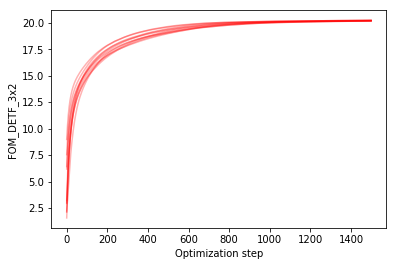

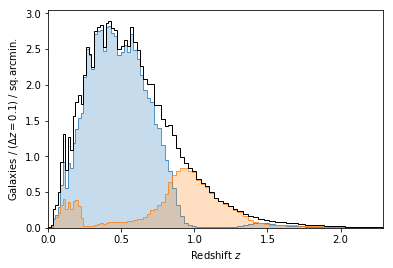

Running job with {'groups': 'group_cos_80_75', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=51.999 (max=52.002) after 750 steps.
  score=53.417 (max=53.421) after 1500 steps.
  score=53.825 (max=53.831) after 2250 steps.
  score=53.999 (max=54.004) after 3000 steps.
trial 1/10: score=53.999 (max=54.004) after 3000 steps.
  score=49.796 (max=54.004) after 750 steps.
  score=52.933 (max=54.004) after 1500 steps.
  score=53.709 (max=54.004) after 2250 steps.
  score=53.950 (max=54.004) after 3000 steps.
trial 2/10: score=53.950 (max=54.004) after 3000 steps.
  score=52.369 (max=54.004) after 750 steps.
  score=53.338 (max=54.004) after 1500 steps.
  score=53.696 (max=54.004) after 2250 steps.
  score=53.875 (max=54.004) after 3000 steps.
trial 3/10: score=53.875 (max=54.004) after 3000 steps.
  score=51.628 (max=54.004) after 750 steps.
  score=53.171 (max=54.004) after 1500 steps.
  score=53.6

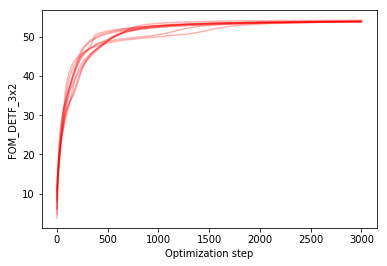

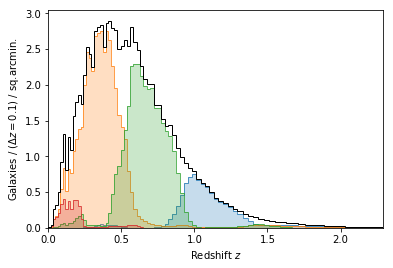

Running job with {'groups': 'group_cos_80_75', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=60.567 (max=60.567) after 1125 steps.
  score=62.574 (max=62.576) after 2250 steps.
  score=64.163 (max=64.163) after 3375 steps.
  score=65.240 (max=65.255) after 4500 steps.
trial 1/10: score=65.240 (max=65.255) after 4500 steps.
  score=65.045 (max=65.255) after 1125 steps.
  score=66.686 (max=66.699) after 2250 steps.
  score=67.721 (max=67.740) after 3375 steps.
  score=68.211 (max=68.227) after 4500 steps.
trial 2/10: score=68.211 (max=68.227) after 4500 steps.
  score=63.491 (max=68.227) after 1125 steps.
  score=65.834 (max=68.227) after 2250 steps.
  score=66.708 (max=68.227) after 3375 steps.
  score=67.195 (max=68.227) after 4500 steps.
trial 3/10: score=67.195 (max=68.227) after 4500 steps.
  score=62.903 (max=68.227) after 1125 steps.
  score=65.343 (max=68.227) after 2250 steps.
  score=

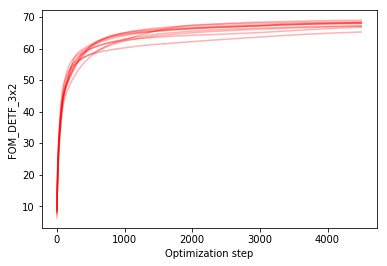

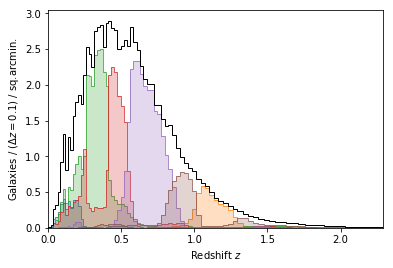

Running job with {'groups': 'group_cos_80_75', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=75.163 (max=75.169) after 1500 steps.
  score=76.981 (max=77.024) after 3000 steps.
  score=77.654 (max=77.666) after 4500 steps.
  score=78.023 (max=78.037) after 6000 steps.
trial 1/10: score=78.023 (max=78.037) after 6000 steps.
  score=73.759 (max=78.037) after 1500 steps.
  score=75.640 (max=78.037) after 3000 steps.
  score=76.190 (max=78.037) after 4500 steps.
  score=76.469 (max=78.037) after 6000 steps.
trial 2/10: score=76.469 (max=78.037) after 6000 steps.
  score=75.780 (max=78.037) after 1500 steps.
  score=77.909 (max=78.037) after 3000 steps.
  score=78.883 (max=78.940) after 4500 steps.
  score=79.455 (max=79.536) after 6000 steps.
trial 3/10: score=79.455 (max=79.536) after 6000 steps.
  score=72.071 (max=79.536) after 1500 steps.
  score=74.680 (max=79.536) after 3000 steps.
  score=

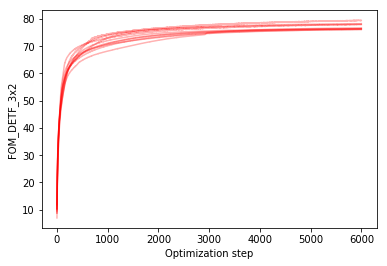

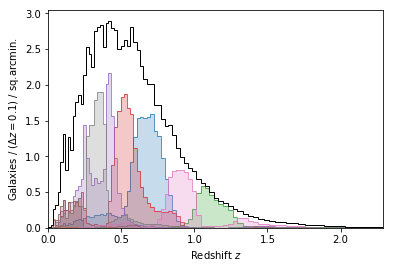

Running job with {'groups': 'group_cos_80_75', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_DETF_3x2', 'method': 'jax', 'seed': 123}
  score=83.848 (max=83.872) after 1875 steps.
  score=85.905 (max=85.920) after 3750 steps.
  score=86.572 (max=86.575) after 5625 steps.
  score=86.863 (max=86.886) after 7500 steps.
trial 1/10: score=86.863 (max=86.886) after 7500 steps.
  score=81.477 (max=86.886) after 1875 steps.
  score=83.910 (max=86.886) after 3750 steps.
  score=85.015 (max=86.886) after 5625 steps.
  score=85.649 (max=86.886) after 7500 steps.
trial 2/10: score=85.649 (max=86.886) after 7500 steps.
  score=81.270 (max=86.886) after 1875 steps.
  score=84.719 (max=86.886) after 3750 steps.
  score=86.242 (max=86.886) after 5625 steps.
  score=86.912 (max=86.943) after 7500 steps.
trial 3/10: score=86.912 (max=86.943) after 7500 steps.
  score=79.942 (max=86.943) after 1875 steps.
  score=83.186 (max=86.943) after 3750 steps.
  score

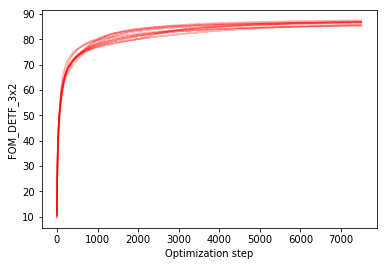

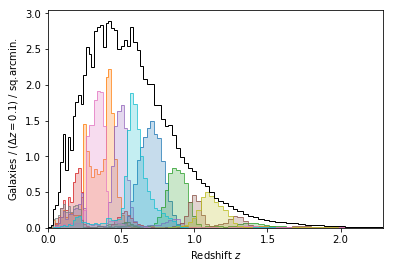

In [42]:
run_study('results/cos-75-detf', optimize_bins)

Running job with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=942.708 (max=942.708) after 375 steps.
  score=947.111 (max=947.111) after 750 steps.
  score=948.532 (max=948.532) after 1125 steps.
  score=949.395 (max=949.395) after 1500 steps.
trial 1/10: score=949.395 (max=949.395) after 1500 steps.
  score=936.098 (max=949.395) after 375 steps.
  score=941.027 (max=949.395) after 750 steps.
  score=942.579 (max=949.395) after 1125 steps.
  score=943.296 (max=949.395) after 1500 steps.
trial 2/10: score=943.296 (max=949.395) after 1500 steps.
  score=936.822 (max=949.395) after 375 steps.
  score=941.858 (max=949.395) after 750 steps.
  score=943.561 (max=949.395) after 1125 steps.
  score=944.268 (max=949.395) after 1500 steps.
trial 3/10: score=944.268 (max=949.395) after 1500 steps.
  score=944.538 (max=949.395) after 375 steps.
  score=949.877 (max=949.877) aft

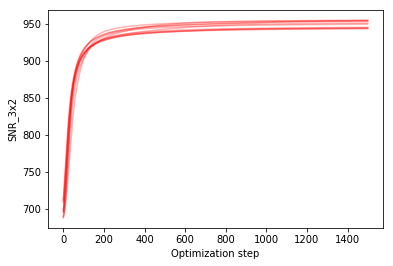

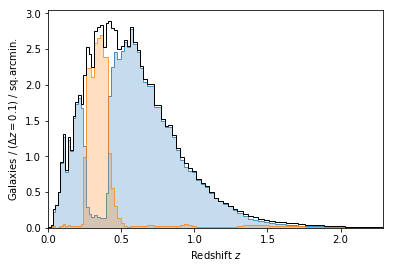

Running job with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1291.276 (max=1291.276) after 750 steps.
  score=1302.706 (max=1302.706) after 1500 steps.
  score=1308.450 (max=1308.450) after 2250 steps.
  score=1310.047 (max=1310.047) after 3000 steps.
trial 1/10: score=1310.047 (max=1310.047) after 3000 steps.
  score=1297.611 (max=1310.047) after 750 steps.
  score=1308.905 (max=1310.047) after 1500 steps.
  score=1311.815 (max=1311.815) after 2250 steps.
  score=1313.294 (max=1313.294) after 3000 steps.
trial 2/10: score=1313.294 (max=1313.294) after 3000 steps.
  score=1295.923 (max=1313.294) after 750 steps.
  score=1307.775 (max=1313.294) after 1500 steps.
  score=1310.773 (max=1313.294) after 2250 steps.
  score=1311.989 (max=1313.294) after 3000 steps.
trial 3/10: score=1311.989 (max=1313.294) after 3000 steps.
  score=1300.240 (max=1313.294) after 750 steps

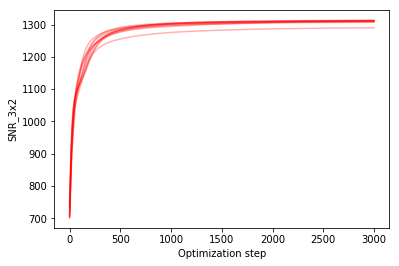

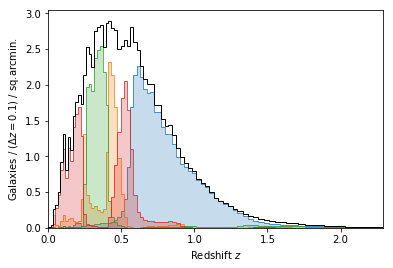

Running job with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1519.549 (max=1519.549) after 1125 steps.
  score=1542.334 (max=1542.334) after 2250 steps.
  score=1546.180 (max=1546.180) after 3375 steps.
  score=1548.208 (max=1548.208) after 4500 steps.
trial 1/10: score=1548.208 (max=1548.208) after 4500 steps.
  score=1524.515 (max=1548.208) after 1125 steps.
  score=1538.709 (max=1548.208) after 2250 steps.
  score=1542.005 (max=1548.208) after 3375 steps.
  score=1543.316 (max=1548.208) after 4500 steps.
trial 2/10: score=1543.316 (max=1548.208) after 4500 steps.
  score=1534.075 (max=1548.208) after 1125 steps.
  score=1550.952 (max=1550.952) after 2250 steps.
  score=1554.652 (max=1554.652) after 3375 steps.
  score=1555.981 (max=1555.981) after 4500 steps.
trial 3/10: score=1555.981 (max=1555.981) after 4500 steps.
  score=1529.539 (max=1555.981) after 1125 s

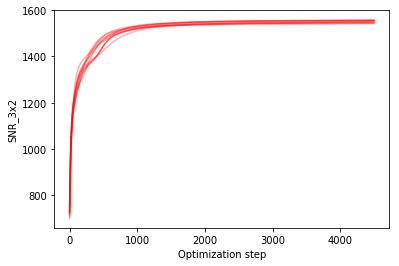

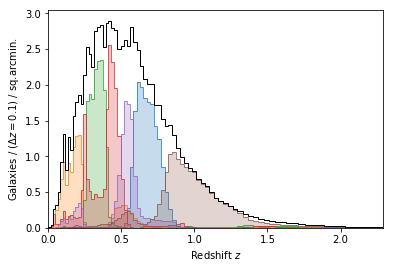

Running job with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1693.133 (max=1693.133) after 1500 steps.
  score=1719.578 (max=1719.578) after 3000 steps.
  score=1723.956 (max=1723.961) after 4500 steps.
  score=1726.375 (max=1726.379) after 6000 steps.
trial 1/10: score=1726.375 (max=1726.379) after 6000 steps.
  score=1693.027 (max=1726.379) after 1500 steps.
  score=1715.803 (max=1726.379) after 3000 steps.
  score=1719.771 (max=1726.379) after 4500 steps.
  score=1721.142 (max=1726.379) after 6000 steps.
trial 2/10: score=1721.142 (max=1726.379) after 6000 steps.
  score=1695.484 (max=1726.379) after 1500 steps.
  score=1713.672 (max=1726.379) after 3000 steps.
  score=1717.326 (max=1726.379) after 4500 steps.
  score=1718.602 (max=1726.379) after 6000 steps.
trial 3/10: score=1718.602 (max=1726.379) after 6000 steps.
  score=1703.383 (max=1726.379) after 1500 s

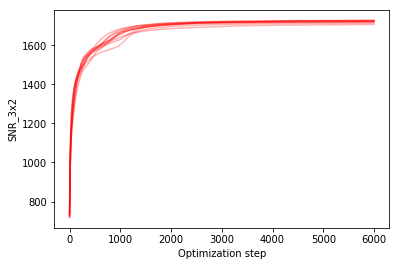

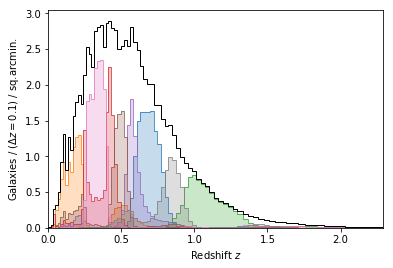

Running job with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'SNR_3x2', 'method': 'jax', 'seed': 123}
  score=1770.638 (max=1770.638) after 1875 steps.
  score=1824.273 (max=1824.273) after 3750 steps.
  score=1831.909 (max=1831.938) after 5625 steps.
  score=1833.583 (max=1833.604) after 7500 steps.
trial 1/10: score=1833.583 (max=1833.604) after 7500 steps.
  score=1804.101 (max=1833.604) after 1875 steps.
  score=1833.209 (max=1833.604) after 3750 steps.
  score=1838.166 (max=1838.166) after 5625 steps.
  score=1839.371 (max=1839.371) after 7500 steps.
trial 2/10: score=1839.371 (max=1839.371) after 7500 steps.
  score=1820.084 (max=1839.371) after 1875 steps.
  score=1841.565 (max=1841.565) after 3750 steps.
  score=1845.455 (max=1845.455) after 5625 steps.
  score=1846.651 (max=1846.651) after 7500 steps.
trial 3/10: score=1846.651 (max=1846.651) after 7500 steps.
  score=1776.626 (max=1846.651) after 1875 

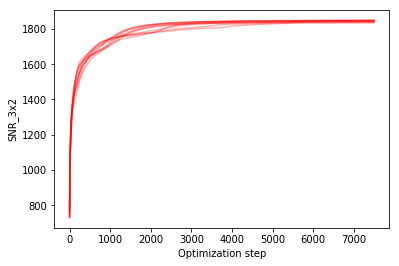

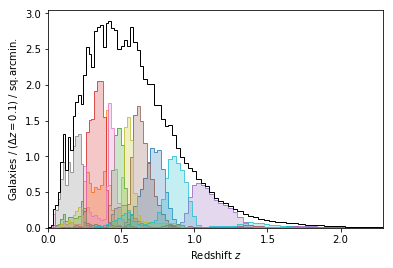

In [43]:
run_study('results/cos-150-snr', optimize_bins)

Running job with {'groups': 'group_cos_80_150', 'nbin': 2, 'ntrial': 10, 'nsteps': 1500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=628.692 (max=628.692) after 375 steps.
  score=651.305 (max=651.305) after 750 steps.
  score=676.604 (max=676.604) after 1125 steps.
  score=683.970 (max=684.079) after 1500 steps.
trial 1/10: score=683.970 (max=684.079) after 1500 steps.
  score=1094.366 (max=1094.366) after 375 steps.
  score=1143.313 (max=1143.313) after 750 steps.
  score=1152.242 (max=1152.251) after 1125 steps.
  score=1155.125 (max=1155.199) after 1500 steps.
trial 2/10: score=1155.125 (max=1155.199) after 1500 steps.
  score=737.999 (max=1155.199) after 375 steps.
  score=796.854 (max=1155.199) after 750 steps.
  score=842.630 (max=1155.199) after 1125 steps.
  score=850.908 (max=1155.199) after 1500 steps.
trial 3/10: score=850.908 (max=1155.199) after 1500 steps.
  score=1092.444 (max=1155.199) after 375 steps.
  score=1180.203

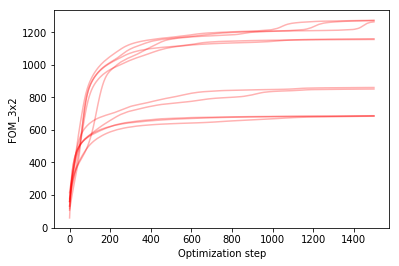

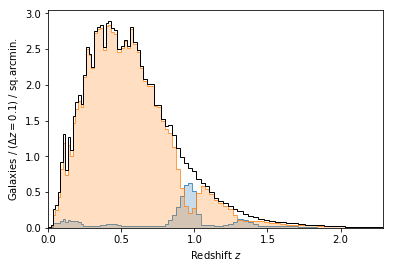

Running job with {'groups': 'group_cos_80_150', 'nbin': 4, 'ntrial': 10, 'nsteps': 3000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=2557.606 (max=2557.606) after 750 steps.
  score=2625.552 (max=2625.636) after 1500 steps.
  score=2637.777 (max=2637.777) after 2250 steps.
  score=2651.751 (max=2651.821) after 3000 steps.
trial 1/10: score=2651.751 (max=2651.821) after 3000 steps.
  score=3088.842 (max=3090.877) after 750 steps.
  score=3438.333 (max=3439.120) after 1500 steps.
  score=3472.220 (max=3472.220) after 2250 steps.
  score=3490.682 (max=3492.919) after 3000 steps.
trial 2/10: score=3490.682 (max=3492.919) after 3000 steps.
  score=2269.160 (max=3492.919) after 750 steps.
  score=2358.375 (max=3492.919) after 1500 steps.
  score=2472.286 (max=3492.919) after 2250 steps.
  score=2509.807 (max=3492.919) after 3000 steps.
trial 3/10: score=2509.807 (max=3492.919) after 3000 steps.
  score=2605.322 (max=3492.919) after 750 steps

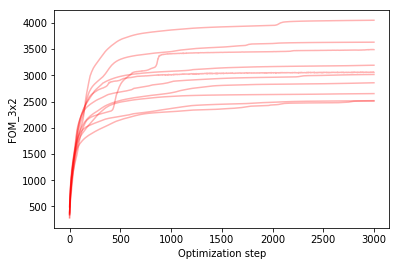

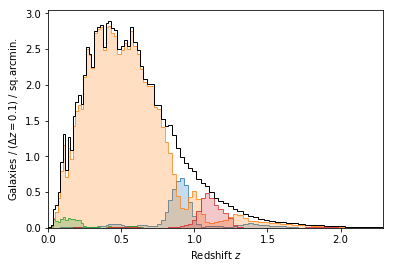

Running job with {'groups': 'group_cos_80_150', 'nbin': 6, 'ntrial': 10, 'nsteps': 4500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=4767.179 (max=4768.056) after 1125 steps.
  score=4834.846 (max=4834.937) after 2250 steps.
  score=4866.367 (max=4866.847) after 3375 steps.
  score=4890.997 (max=4891.717) after 4500 steps.
trial 1/10: score=4890.997 (max=4891.717) after 4500 steps.
  score=4736.524 (max=4891.717) after 1125 steps.
  score=4900.524 (max=4901.367) after 2250 steps.
  score=4952.471 (max=4953.296) after 3375 steps.
  score=4999.146 (max=4999.704) after 4500 steps.
trial 2/10: score=4999.146 (max=4999.704) after 4500 steps.
  score=4757.829 (max=4999.704) after 1125 steps.
  score=5130.849 (max=5131.779) after 2250 steps.
  score=5233.356 (max=5233.931) after 3375 steps.
  score=5295.909 (max=5295.979) after 4500 steps.
trial 3/10: score=5295.909 (max=5295.979) after 4500 steps.
  score=5097.724 (max=5295.979) after 1125 s

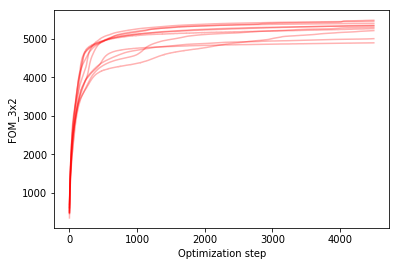

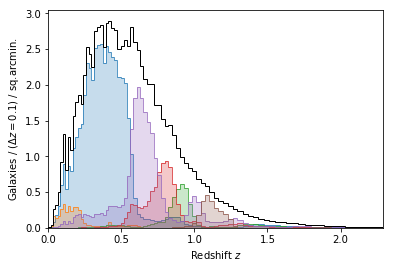

Running job with {'groups': 'group_cos_80_150', 'nbin': 8, 'ntrial': 10, 'nsteps': 6000, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=5797.481 (max=5797.547) after 1500 steps.
  score=5905.407 (max=5905.407) after 3000 steps.
  score=5949.309 (max=5949.860) after 4500 steps.
  score=5972.938 (max=5973.792) after 6000 steps.
trial 1/10: score=5972.938 (max=5973.792) after 6000 steps.
  score=6058.998 (max=6060.216) after 1500 steps.
  score=6185.298 (max=6185.298) after 3000 steps.
  score=6236.504 (max=6239.290) after 4500 steps.
  score=6272.706 (max=6274.130) after 6000 steps.
trial 2/10: score=6272.706 (max=6274.130) after 6000 steps.
  score=6513.103 (max=6513.136) after 1500 steps.
  score=6633.807 (max=6634.304) after 3000 steps.
  score=6679.380 (max=6680.286) after 4500 steps.
  score=6704.885 (max=6707.529) after 6000 steps.
trial 3/10: score=6704.885 (max=6707.529) after 6000 steps.
  score=6681.690 (max=6707.529) after 1500 s

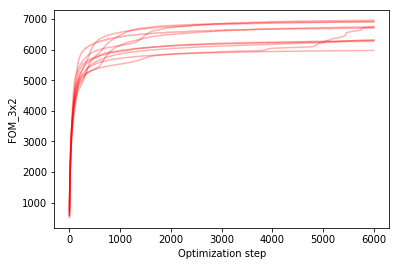

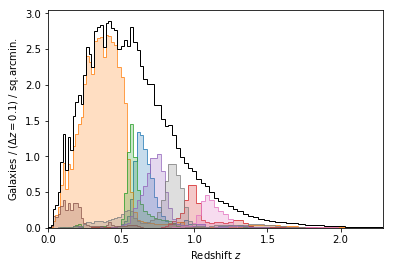

Running job with {'groups': 'group_cos_80_150', 'nbin': 10, 'ntrial': 10, 'nsteps': 7500, 'eta': 0.02, 'transform': 'extend', 'metric': 'FOM_3x2', 'method': 'jax', 'seed': 123}
  score=7285.607 (max=7285.607) after 1875 steps.
  score=7468.457 (max=7469.752) after 3750 steps.
  score=7558.471 (max=7561.066) after 5625 steps.
  score=7601.975 (max=7603.190) after 7500 steps.
trial 1/10: score=7601.975 (max=7603.190) after 7500 steps.
  score=7246.026 (max=7603.190) after 1875 steps.
  score=7442.575 (max=7603.190) after 3750 steps.
  score=7508.933 (max=7603.190) after 5625 steps.
  score=7538.330 (max=7603.190) after 7500 steps.
trial 2/10: score=7538.330 (max=7603.190) after 7500 steps.
  score=7374.828 (max=7603.190) after 1875 steps.
  score=7494.766 (max=7603.190) after 3750 steps.
  score=7546.178 (max=7603.190) after 5625 steps.
  score=7567.328 (max=7603.190) after 7500 steps.
trial 3/10: score=7567.328 (max=7603.190) after 7500 steps.
  score=7207.866 (max=7603.190) after 1875 

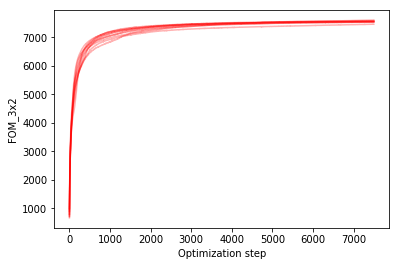

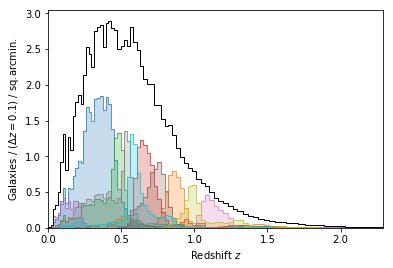

In [44]:
run_study('results/cos-150-fom', optimize_bins)

## Optimize Neural Network Classifier

In [10]:
ndata = 2000000
with np.load('uniform_buz_riz.npz') as keys:
    X = jnp.array(3 * (keys['uniform'][:ndata] - 0.5))
    z = jnp.array(keys['redshift'][:ndata])
print(f'Loaded {len(X)} training samples with ~uniform distribution.')

Loaded 2000000 training samples with ~uniform distribution.


Learn a dense classifier using jax to build and optimize the network:

In [11]:
def learn_nnet(nbin=2, X=X, z=z, trainfrac=0.5, nhidden=64, nlayer=2, ntrial=1, nepoch=100, batchsize=50000, interval=10, eta=0.001,
               init_data=init_data, metric='FOM_DETF_3x2', gals_per_arcmin2=20., fsky=0.25, seed=123):
    """
    """
    # Calculate the normalized dndz for each bin.
    zedges = jnp.array(init_data[0])
    def hist1bin(z, w):
        return jnp.histogram(z, bins=zedges, weights=w)[0]
    histbins = jax.vmap(hist1bin, in_axes=(None, 1), out_axes=0)
    
    # Build the network model.
    layers = []
    for i in range(nlayer):
        layers.extend([
            stax.Dense(nhidden),
            stax.LeakyRelu,
            stax.BatchNorm(axis=(0,1)),
        ])
    layers.extend([
        stax.Dense(nbin),
        stax.Softmax
    ])
    init_fun, apply_fun = stax.serial(*layers)
    
    def get_weights(params, Xb, zb):
        # Get normalized weights from the network model.
        wgts = apply_fun(params, Xb)
        # Convert to a normalized dndz for each bin.
        w = histbins(zb, wgts)
        return w / zb.shape[0]        
    
    # Evaluate all 3x2 metrics.
    def metrics(params, Xb, zb):
        w = get_weights(params, Xb, zb)
        # Use the same binning for number density and weak lensing.
        weights = jnp.array([w, w])
        return reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2, fsky)
    
    # Evaluate the loss as -metric.
    def loss(params, Xb, zb):
        return -metrics(params, Xb, zb)[metric]
    
    opt_init, opt_update, get_params = optimizers.adam(eta)
    
    # Define the update rule.
    @jax.jit
    def update(i, opt_state, Xb, zb):
        params = get_params(opt_state)
        grads = jax.grad(loss)(params, Xb, zb)
        return opt_update(i, grads, opt_state)
    
    rng = jax.random.PRNGKey(seed)
    gen = np.random.RandomState(seed)
    
    ndata = X.shape[0]
    ntrain = int(np.round(ndata * trainfrac))
    Xtrain, ztrain = X[:ntrain], z[:ntrain]
    Xvalid, zvalid = X[ntrain:], z[ntrain:]
    nbatch = ntrain // batchsize
    
    all_scores = []
    max_score = -1
    best_params = None
    
    for trial in range(ntrial):
    
        _, init_params = init_fun(rng, (batchsize, X.shape[1]))
        opt_state = opt_init(init_params)

        all_scores.append([])
        itercount = itertools.count()
        for epoch in range(nepoch):
            perm = gen.permutation(ntrain)
            for batch in range(nbatch):
                idx = perm[batch * batchsize:(batch + 1) * batchsize]
                opt_state = update(next(itercount), opt_state, Xtrain[idx], ztrain[idx])
            # Calculate train and validation scores after this epoch.
            params = get_params(opt_state)
            train_score = metrics(params, Xtrain, ztrain)[metric]
            all_scores[-1].append(train_score)
            if train_score > max_score:
                best_params = params
                max_score = train_score
            if epoch % interval == 0:
                valid_score = metrics(params, Xvalid, zvalid)[metric]
                print(f'Trial {trial+1}/{ntrial} epoch {epoch+1}/{nepoch} train {train_score:.3f} (max {max_score:.3f}) validation {valid_score:.3f}.')

    # Calculate all metrics for the best params.
    best_scores = metrics(best_params, Xtrain, ztrain)
    best_scores = {metric: float(value) for metric, value in best_scores.items()}
    
    # Convert the best parameters to normalized dndz weights.
    dndz_bin = get_weights(best_params, Xtrain, ztrain)

    return best_scores, dndz_bin, all_scores

Starting job at 2020-09-11 12:44:30.535438 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 123}
Trial 1/3 epoch 1/100 train 18.561 (max 18.561) validation 18.625.
Trial 1/3 epoch 11/100 train 20.705 (max 20.706) validation 20.743.
Trial 1/3 epoch 21/100 train 20.738 (max 20.742) validation 20.767.
Trial 1/3 epoch 31/100 train 20.867 (max 20.867) validation 20.897.
Trial 1/3 epoch 41/100 train 20.899 (max 20.909) validation 20.917.
Trial 1/3 epoch 51/100 train 20.905 (max 20.928) validation 20.927.
Trial 1/3 epoch 61/100 train 20.919 (max 20.939) validation 20.932.
Trial 1/3 epoch 71/100 train 20.922 (max 20.948) validation 20.946.
Trial 1/3 epoch 81/100 train 20.938 (max 20.949) validation 20.953.
Trial 1/3 epoch 91/100 train 20.925 (max 20.952) validation 20.963.
Trial 2/3 epoch 1/100 train 18.571 (max 21.020) validation 18.635.
Trial 2/3 epoch 11/100 train 20.665 (max 21.020

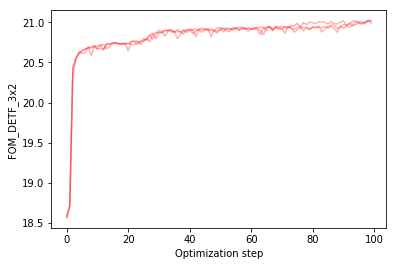

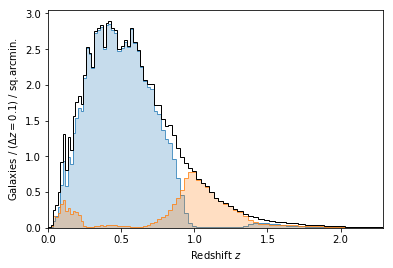

Starting job at 2020-09-11 12:49:38.241520 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 123}
Trial 1/3 epoch 1/100 train 53.708 (max 53.708) validation 53.644.
Trial 1/3 epoch 11/100 train 57.284 (max 57.284) validation 57.264.
Trial 1/3 epoch 21/100 train 57.658 (max 57.658) validation 57.634.
Trial 1/3 epoch 31/100 train 58.095 (max 58.118) validation 58.030.
Trial 1/3 epoch 41/100 train 58.361 (max 58.446) validation 58.327.
Trial 1/3 epoch 51/100 train 58.701 (max 58.701) validation 58.750.
Trial 1/3 epoch 61/100 train 58.583 (max 58.749) validation 58.681.
Trial 1/3 epoch 71/100 train 58.589 (max 58.781) validation 58.726.
Trial 1/3 epoch 81/100 train 58.819 (max 58.819) validation 58.877.
Trial 1/3 epoch 91/100 train 58.807 (max 58.819) validation 58.957.
Trial 2/3 epoch 1/100 train 53.727 (max 58.843) validation 53.660.
Trial 2/3 epoch 11/100 train 57.208 (max 58.843

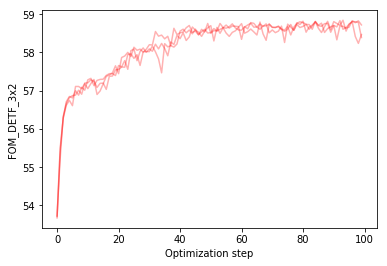

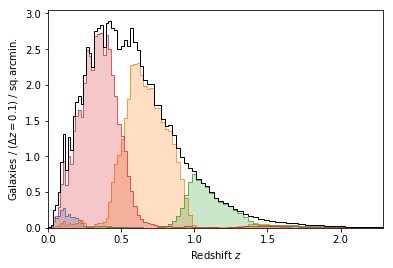

Starting job at 2020-09-11 12:55:49.024223 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 123}
Trial 1/3 epoch 1/100 train 67.436 (max 67.436) validation 67.299.
Trial 1/3 epoch 11/100 train 71.927 (max 71.927) validation 71.902.
Trial 1/3 epoch 21/100 train 73.741 (max 73.741) validation 73.651.
Trial 1/3 epoch 31/100 train 74.202 (max 74.202) validation 74.099.
Trial 1/3 epoch 41/100 train 74.129 (max 74.249) validation 74.035.
Trial 1/3 epoch 51/100 train 74.443 (max 74.443) validation 74.365.
Trial 1/3 epoch 61/100 train 74.514 (max 74.514) validation 74.332.
Trial 1/3 epoch 71/100 train 74.111 (max 74.530) validation 74.092.
Trial 1/3 epoch 81/100 train 74.657 (max 74.657) validation 74.602.
Trial 1/3 epoch 91/100 train 74.857 (max 74.857) validation 74.937.
Trial 2/3 epoch 1/100 train 67.489 (max 74.900) validation 67.356.
Trial 2/3 epoch 11/100 train 71.622 (max 74.900

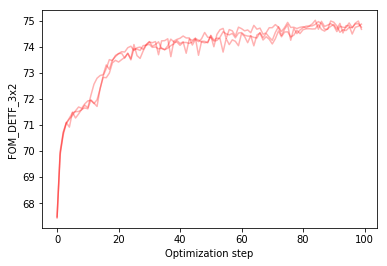

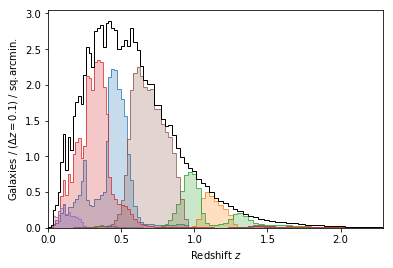

Starting job at 2020-09-11 13:06:41.969509 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 123}
Trial 1/3 epoch 1/100 train 76.577 (max 76.577) validation 76.479.
Trial 1/3 epoch 11/100 train 84.168 (max 84.168) validation 84.052.
Trial 1/3 epoch 21/100 train 85.772 (max 85.870) validation 85.670.
Trial 1/3 epoch 31/100 train 86.200 (max 86.200) validation 86.177.
Trial 1/3 epoch 41/100 train 86.603 (max 86.617) validation 86.540.
Trial 1/3 epoch 51/100 train 86.677 (max 86.679) validation 86.634.
Trial 1/3 epoch 61/100 train 86.773 (max 86.829) validation 86.693.
Trial 1/3 epoch 71/100 train 86.475 (max 86.887) validation 86.524.
Trial 1/3 epoch 81/100 train 86.765 (max 86.939) validation 86.649.
Trial 1/3 epoch 91/100 train 86.939 (max 86.939) validation 86.834.
Trial 2/3 epoch 1/100 train 76.522 (max 87.017) validation 76.447.
Trial 2/3 epoch 11/100 train 84.032 (max 87.017

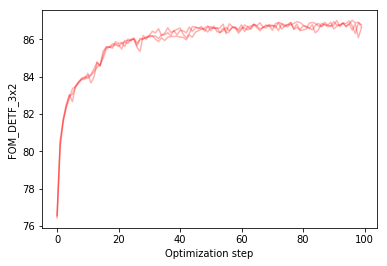

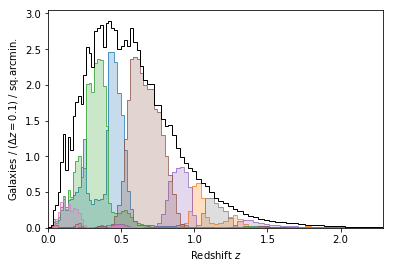

Starting job at 2020-09-11 13:20:04.673191 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 123}
Trial 1/3 epoch 1/100 train 82.070 (max 82.070) validation 81.861.
Trial 1/3 epoch 11/100 train 93.344 (max 93.344) validation 93.175.
Trial 1/3 epoch 21/100 train 94.552 (max 94.552) validation 94.529.
Trial 1/3 epoch 31/100 train 95.638 (max 95.638) validation 95.557.
Trial 1/3 epoch 41/100 train 95.629 (max 95.814) validation 95.603.
Trial 1/3 epoch 51/100 train 95.802 (max 95.946) validation 95.705.
Trial 1/3 epoch 61/100 train 95.691 (max 96.127) validation 95.607.
Trial 1/3 epoch 71/100 train 95.854 (max 96.165) validation 95.854.
Trial 1/3 epoch 81/100 train 96.275 (max 96.291) validation 96.144.
Trial 1/3 epoch 91/100 train 95.998 (max 96.291) validation 95.978.
Trial 2/3 epoch 1/100 train 81.977 (max 96.520) validation 81.765.
Trial 2/3 epoch 11/100 train 93.427 (max 96.52

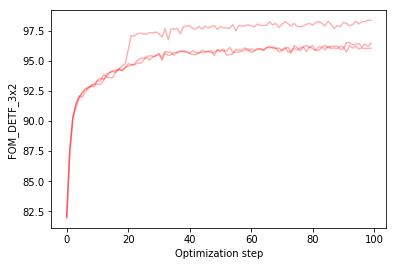

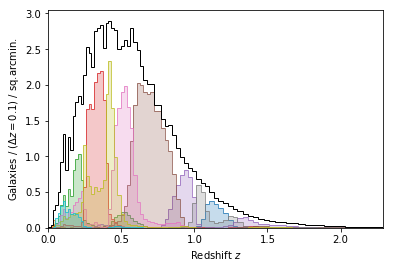

In [95]:
run_study('results/nn-3-64-detf', learn_nnet, rerun='all')

Skipping already completed job for nbin=2
Skipping already completed job for nbin=4
Starting job at 2020-09-11 14:47:58.476010 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 150, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 63.393 (max 63.393) validation 63.526.
Trial 1/3 epoch 11/200 train 71.397 (max 71.397) validation 71.440.
Trial 1/3 epoch 21/200 train 73.240 (max 73.240) validation 73.135.
Trial 1/3 epoch 31/200 train 73.761 (max 73.761) validation 73.742.
Trial 1/3 epoch 41/200 train 73.876 (max 73.948) validation 73.848.
Trial 1/3 epoch 51/200 train 73.916 (max 74.106) validation 73.909.
Trial 1/3 epoch 61/200 train 73.892 (max 74.160) validation 73.881.
Trial 1/3 epoch 71/200 train 74.085 (max 74.292) validation 73.967.
Trial 1/3 epoch 81/200 train 74.416 (max 74.478) validation 74.416.
Trial 1/3 epoch 91/200 train 74.620 (max 74.686) validation 74.578.
Trial 1/3 epoch 101/200 train 7

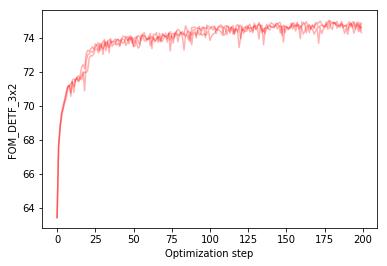

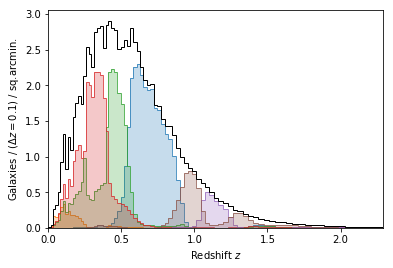

Starting job at 2020-09-11 14:58:20.382672 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 200, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 77.998 (max 77.998) validation 78.045.
Trial 1/3 epoch 11/200 train 83.989 (max 84.088) validation 84.053.
Trial 1/3 epoch 21/200 train 85.207 (max 85.207) validation 85.036.
Trial 1/3 epoch 31/200 train 85.564 (max 85.619) validation 85.445.
Trial 1/3 epoch 41/200 train 85.771 (max 85.924) validation 85.482.
Trial 1/3 epoch 51/200 train 86.158 (max 86.455) validation 86.029.
Trial 1/3 epoch 61/200 train 86.412 (max 86.539) validation 86.334.
Trial 1/3 epoch 71/200 train 86.575 (max 86.680) validation 86.583.
Trial 1/3 epoch 81/200 train 86.372 (max 86.680) validation 86.271.
Trial 1/3 epoch 91/200 train 86.706 (max 86.769) validation 86.594.
Trial 1/3 epoch 101/200 train 86.782 (max 86.784) validation 86.667.
Trial 1/3 epoch 111/200 train 86.574 (max 86.8

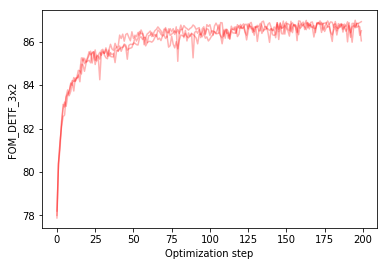

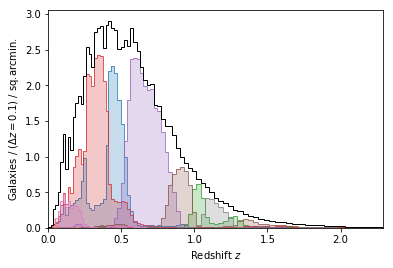

Starting job at 2020-09-11 15:11:39.733902 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 250, 'nlayer': 3, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 84.027 (max 84.027) validation 84.104.
Trial 1/3 epoch 11/200 train 94.238 (max 94.539) validation 94.506.
Trial 1/3 epoch 21/200 train 95.899 (max 96.360) validation 95.963.
Trial 1/3 epoch 31/200 train 96.806 (max 96.806) validation 96.950.
Trial 1/3 epoch 41/200 train 96.148 (max 97.194) validation 96.404.
Trial 1/3 epoch 51/200 train 97.020 (max 97.275) validation 97.052.
Trial 1/3 epoch 61/200 train 97.243 (max 97.455) validation 97.323.
Trial 1/3 epoch 71/200 train 96.953 (max 97.511) validation 96.858.
Trial 1/3 epoch 81/200 train 97.470 (max 97.511) validation 97.369.
Trial 1/3 epoch 91/200 train 97.364 (max 97.518) validation 97.385.
Trial 1/3 epoch 101/200 train 97.009 (max 97.552) validation 96.928.
Trial 1/3 epoch 111/200 train 97.680 (max 97.

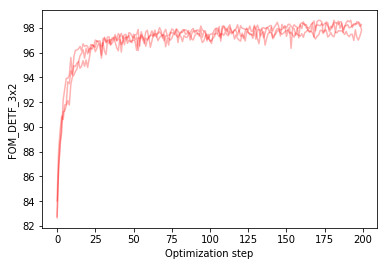

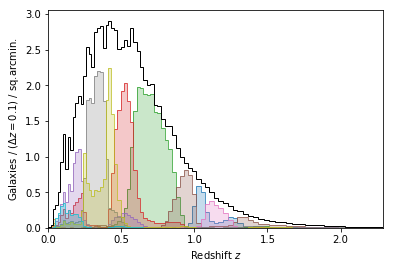

In [12]:
run_study('results/nn-3-detf', learn_nnet)

Starting job at 2020-09-11 16:16:09.533726 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 20.028 (max 20.028) validation 20.012.
Trial 1/3 epoch 11/200 train 20.672 (max 20.672) validation 20.644.
Trial 1/3 epoch 21/200 train 20.728 (max 20.728) validation 20.696.
Trial 1/3 epoch 31/200 train 20.703 (max 20.728) validation 20.670.
Trial 1/3 epoch 41/200 train 20.729 (max 20.757) validation 20.710.
Trial 1/3 epoch 51/200 train 20.870 (max 20.880) validation 20.814.
Trial 1/3 epoch 61/200 train 20.860 (max 20.910) validation 20.801.
Trial 1/3 epoch 71/200 train 20.917 (max 20.917) validation 20.858.
Trial 1/3 epoch 81/200 train 20.916 (max 20.923) validation 20.875.
Trial 1/3 epoch 91/200 train 20.882 (max 20.937) validation 20.812.
Trial 1/3 epoch 101/200 train 20.895 (max 20.937) validation 20.853.
Trial 1/3 epoch 111/200 train 20.910 (max 20.93

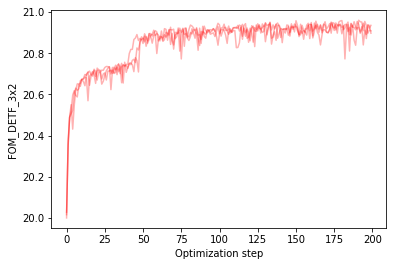

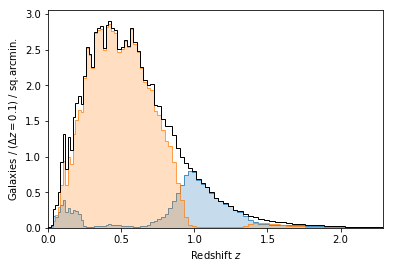

Starting job at 2020-09-11 16:20:07.058277 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 52.448 (max 52.448) validation 52.670.
Trial 1/3 epoch 11/200 train 57.097 (max 57.097) validation 57.134.
Trial 1/3 epoch 21/200 train 57.435 (max 57.459) validation 57.397.
Trial 1/3 epoch 31/200 train 58.125 (max 58.125) validation 58.010.
Trial 1/3 epoch 41/200 train 58.190 (max 58.190) validation 58.228.
Trial 1/3 epoch 51/200 train 58.173 (max 58.261) validation 58.057.
Trial 1/3 epoch 61/200 train 58.266 (max 58.309) validation 58.159.
Trial 1/3 epoch 71/200 train 57.976 (max 58.337) validation 57.957.
Trial 1/3 epoch 81/200 train 58.249 (max 58.337) validation 58.240.
Trial 1/3 epoch 91/200 train 58.426 (max 58.426) validation 58.295.
Trial 1/3 epoch 101/200 train 58.494 (max 58.494) validation 58.318.
Trial 1/3 epoch 111/200 train 58.424 (max 58.49

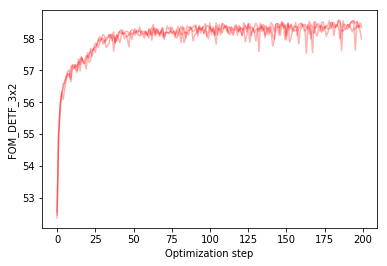

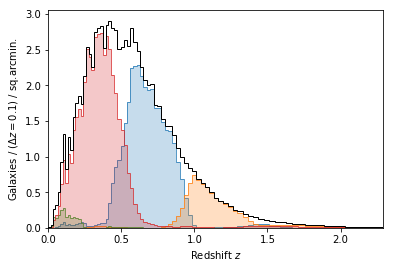

Starting job at 2020-09-11 16:25:11.594653 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 62.604 (max 62.604) validation 62.914.
Trial 1/3 epoch 11/200 train 71.628 (max 71.628) validation 71.563.
Trial 1/3 epoch 21/200 train 71.917 (max 72.027) validation 71.787.
Trial 1/3 epoch 31/200 train 72.587 (max 72.587) validation 72.322.
Trial 1/3 epoch 41/200 train 73.090 (max 73.090) validation 73.029.
Trial 1/3 epoch 51/200 train 73.247 (max 73.337) validation 73.293.
Trial 1/3 epoch 61/200 train 73.081 (max 73.357) validation 73.089.
Trial 1/3 epoch 71/200 train 73.317 (max 73.459) validation 73.418.
Trial 1/3 epoch 81/200 train 73.596 (max 73.596) validation 73.661.
Trial 1/3 epoch 91/200 train 73.575 (max 73.668) validation 73.600.
Trial 1/3 epoch 101/200 train 73.526 (max 73.680) validation 73.341.
Trial 1/3 epoch 111/200 train 73.677 (max 73.83

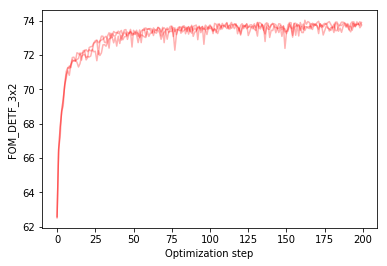

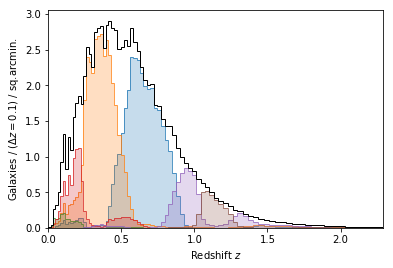

Starting job at 2020-09-11 16:33:43.687299 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 68.783 (max 68.783) validation 68.912.
Trial 1/3 epoch 11/200 train 83.427 (max 83.427) validation 83.512.
Trial 1/3 epoch 21/200 train 85.189 (max 85.189) validation 85.064.
Trial 1/3 epoch 31/200 train 86.329 (max 86.329) validation 86.381.
Trial 1/3 epoch 41/200 train 86.522 (max 86.639) validation 86.489.
Trial 1/3 epoch 51/200 train 86.695 (max 86.966) validation 86.640.
Trial 1/3 epoch 61/200 train 86.502 (max 86.966) validation 86.344.
Trial 1/3 epoch 71/200 train 86.845 (max 87.027) validation 86.917.
Trial 1/3 epoch 81/200 train 87.003 (max 87.153) validation 86.949.
Trial 1/3 epoch 91/200 train 86.652 (max 87.190) validation 86.505.
Trial 1/3 epoch 101/200 train 87.128 (max 87.282) validation 87.044.
Trial 1/3 epoch 111/200 train 87.218 (max 87.30

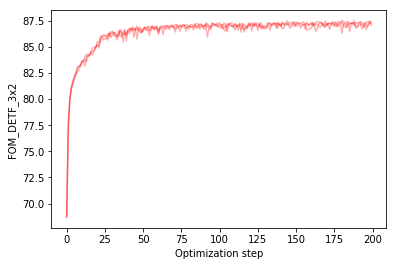

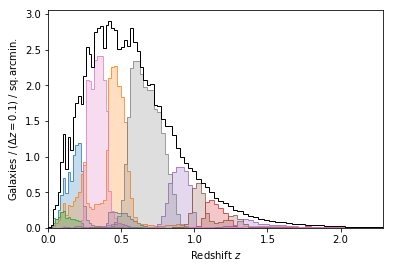

Starting job at 2020-09-11 16:44:08.125104 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 4, 'nepoch': 200, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/200 train 71.514 (max 71.514) validation 71.779.
Trial 1/3 epoch 11/200 train 92.433 (max 92.433) validation 92.402.
Trial 1/3 epoch 21/200 train 93.489 (max 93.489) validation 93.416.
Trial 1/3 epoch 31/200 train 93.950 (max 94.722) validation 94.132.
Trial 1/3 epoch 41/200 train 95.078 (max 95.508) validation 95.016.
Trial 1/3 epoch 51/200 train 95.627 (max 95.782) validation 95.616.
Trial 1/3 epoch 61/200 train 95.951 (max 96.105) validation 95.992.
Trial 1/3 epoch 71/200 train 96.072 (max 96.261) validation 96.070.
Trial 1/3 epoch 81/200 train 96.501 (max 96.722) validation 96.380.
Trial 1/3 epoch 91/200 train 96.484 (max 96.722) validation 96.426.
Trial 1/3 epoch 101/200 train 96.978 (max 96.978) validation 96.903.
Trial 1/3 epoch 111/200 train 96.773 (max 97.1

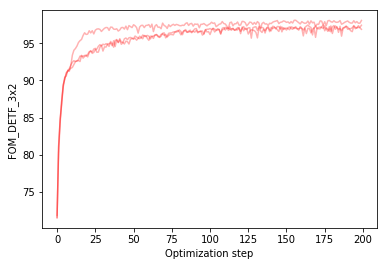

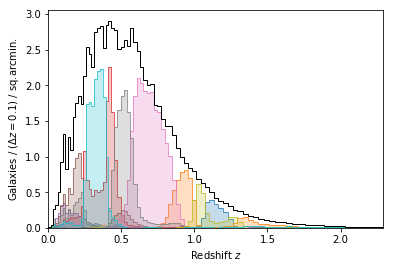

In [14]:
run_study('results/nn-4-64-detf', learn_nnet)

Starting job at 2020-09-11 17:00:48.616372 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 16.903 (max 16.903) validation 16.828.
Trial 1/3 epoch 11/100 train 19.442 (max 19.442) validation 19.411.
Trial 1/3 epoch 21/100 train 20.577 (max 20.577) validation 20.542.
Trial 1/3 epoch 31/100 train 20.600 (max 20.632) validation 20.564.
Trial 1/3 epoch 41/100 train 20.665 (max 20.665) validation 20.634.
Trial 1/3 epoch 51/100 train 20.695 (max 20.695) validation 20.670.
Trial 1/3 epoch 61/100 train 20.695 (max 20.710) validation 20.667.
Trial 1/3 epoch 71/100 train 20.709 (max 20.710) validation 20.674.
Trial 1/3 epoch 81/100 train 20.686 (max 20.722) validation 20.668.
Trial 1/3 epoch 91/100 train 20.702 (max 20.729) validation 20.679.
Trial 2/3 epoch 1/100 train 16.905 (max 20.731) validation 16.833.
Trial 2/3 epoch 11/100 train 19.618 (max 20.731) 

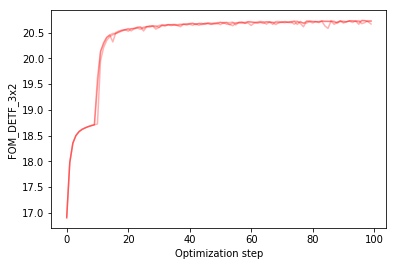

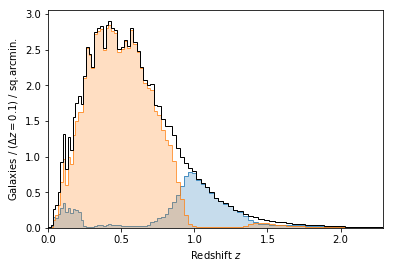

Starting job at 2020-09-11 17:02:29.794466 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 46.166 (max 46.166) validation 46.230.
Trial 1/3 epoch 11/100 train 55.865 (max 55.865) validation 56.004.
Trial 1/3 epoch 21/100 train 56.532 (max 56.783) validation 56.725.
Trial 1/3 epoch 31/100 train 57.014 (max 57.060) validation 57.045.
Trial 1/3 epoch 41/100 train 56.965 (max 57.188) validation 57.040.
Trial 1/3 epoch 51/100 train 57.244 (max 57.244) validation 57.288.
Trial 1/3 epoch 61/100 train 57.233 (max 57.387) validation 57.242.
Trial 1/3 epoch 71/100 train 57.580 (max 57.580) validation 57.487.
Trial 1/3 epoch 81/100 train 57.931 (max 57.931) validation 57.897.
Trial 1/3 epoch 91/100 train 57.974 (max 57.974) validation 57.948.
Trial 2/3 epoch 1/100 train 46.149 (max 58.062) validation 46.207.
Trial 2/3 epoch 11/100 train 55.798 (max 58.062) 

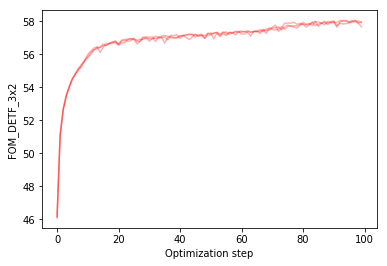

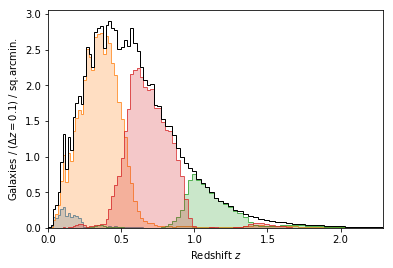

Starting job at 2020-09-11 17:04:37.280846 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 57.500 (max 57.500) validation 57.634.
Trial 1/3 epoch 11/100 train 70.495 (max 70.495) validation 70.492.
Trial 1/3 epoch 21/100 train 71.524 (max 71.543) validation 71.580.
Trial 1/3 epoch 31/100 train 72.167 (max 72.167) validation 72.106.
Trial 1/3 epoch 41/100 train 73.214 (max 73.214) validation 73.143.
Trial 1/3 epoch 51/100 train 73.522 (max 73.522) validation 73.458.
Trial 1/3 epoch 61/100 train 73.288 (max 73.543) validation 73.245.
Trial 1/3 epoch 71/100 train 73.747 (max 73.747) validation 73.623.
Trial 1/3 epoch 81/100 train 73.756 (max 73.799) validation 73.698.
Trial 1/3 epoch 91/100 train 73.859 (max 73.859) validation 73.791.
Trial 2/3 epoch 1/100 train 57.631 (max 73.891) validation 57.762.
Trial 2/3 epoch 11/100 train 70.689 (max 73.891) 

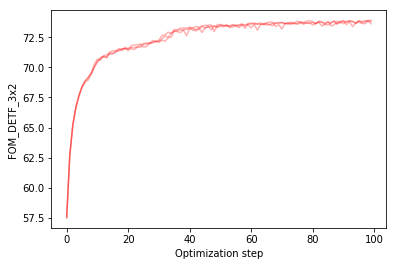

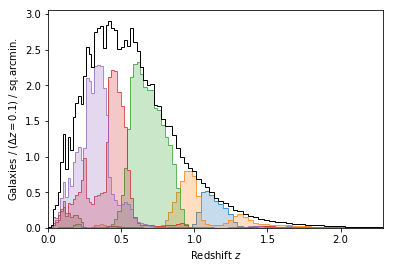

Starting job at 2020-09-11 17:08:28.532964 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 59.082 (max 59.082) validation 59.442.
Trial 1/3 epoch 11/100 train 81.649 (max 81.649) validation 81.799.
Trial 1/3 epoch 21/100 train 82.735 (max 82.763) validation 82.814.
Trial 1/3 epoch 31/100 train 83.193 (max 83.193) validation 83.249.
Trial 1/3 epoch 41/100 train 83.056 (max 83.320) validation 83.266.
Trial 1/3 epoch 51/100 train 83.544 (max 83.605) validation 83.678.
Trial 1/3 epoch 61/100 train 83.820 (max 83.898) validation 83.981.
Trial 1/3 epoch 71/100 train 84.063 (max 84.090) validation 84.215.
Trial 1/3 epoch 81/100 train 84.097 (max 84.362) validation 84.287.
Trial 1/3 epoch 91/100 train 85.305 (max 85.305) validation 85.215.
Trial 2/3 epoch 1/100 train 59.541 (max 85.637) validation 59.891.
Trial 2/3 epoch 11/100 train 81.547 (max 85.637) 

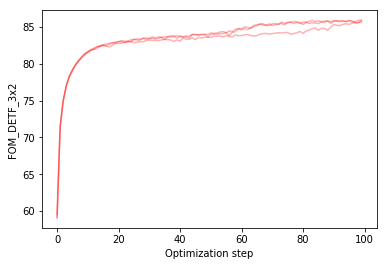

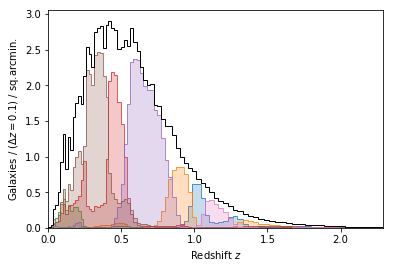

Starting job at 2020-09-11 17:13:15.111614 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 2, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_DETF_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 64.130 (max 64.130) validation 64.622.
Trial 1/3 epoch 11/100 train 90.203 (max 90.203) validation 90.285.
Trial 1/3 epoch 21/100 train 91.876 (max 92.064) validation 91.939.
Trial 1/3 epoch 31/100 train 92.919 (max 92.919) validation 92.873.
Trial 1/3 epoch 41/100 train 93.623 (max 93.623) validation 93.637.
Trial 1/3 epoch 51/100 train 93.968 (max 93.968) validation 93.962.
Trial 1/3 epoch 61/100 train 94.113 (max 94.182) validation 94.072.
Trial 1/3 epoch 71/100 train 94.229 (max 94.308) validation 94.221.
Trial 1/3 epoch 81/100 train 94.263 (max 94.390) validation 94.265.
Trial 1/3 epoch 91/100 train 94.402 (max 94.485) validation 94.359.
Trial 2/3 epoch 1/100 train 64.379 (max 94.538) validation 64.862.
Trial 2/3 epoch 11/100 train 90.224 (max 94.538)

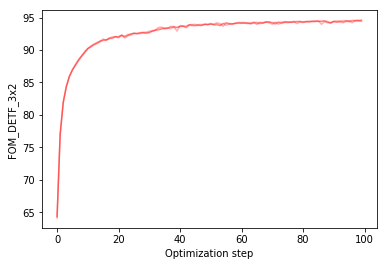

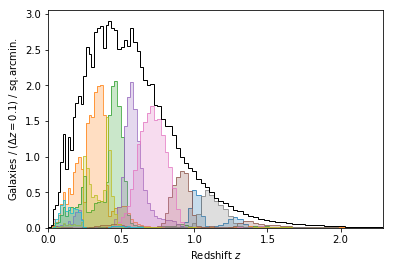

In [15]:
run_study('results/nn-2-64-detf', learn_nnet)

Starting job at 2020-09-11 17:38:11.836928 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 948.765 (max 948.765) validation 948.666.
Trial 1/3 epoch 11/100 train 955.966 (max 955.966) validation 955.855.
Trial 1/3 epoch 21/100 train 956.472 (max 956.472) validation 956.313.
Trial 1/3 epoch 31/100 train 956.651 (max 956.661) validation 956.480.
Trial 1/3 epoch 41/100 train 956.776 (max 956.776) validation 956.586.
Trial 1/3 epoch 51/100 train 956.855 (max 956.855) validation 956.686.
Trial 1/3 epoch 61/100 train 956.867 (max 956.883) validation 956.702.
Trial 1/3 epoch 71/100 train 956.933 (max 956.933) validation 956.762.
Trial 1/3 epoch 81/100 train 956.893 (max 956.949) validation 956.727.
Trial 1/3 epoch 91/100 train 956.949 (max 956.988) validation 956.760.
Trial 2/3 epoch 1/100 train 948.755 (max 956.988) validation 948.657.
Trial 2/3 epoch 11/10

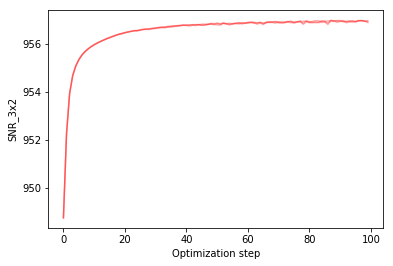

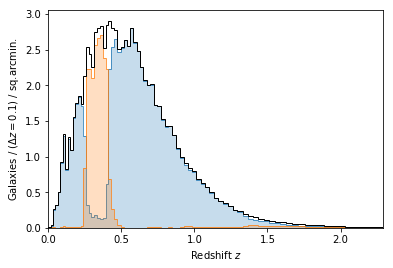

Starting job at 2020-09-11 17:39:55.004397 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1268.053 (max 1268.053) validation 1268.368.
Trial 1/3 epoch 11/100 train 1313.398 (max 1313.398) validation 1313.257.
Trial 1/3 epoch 21/100 train 1317.220 (max 1317.220) validation 1317.070.
Trial 1/3 epoch 31/100 train 1320.475 (max 1320.475) validation 1320.432.
Trial 1/3 epoch 41/100 train 1321.681 (max 1321.681) validation 1321.639.
Trial 1/3 epoch 51/100 train 1322.344 (max 1322.344) validation 1322.328.
Trial 1/3 epoch 61/100 train 1322.591 (max 1322.591) validation 1322.506.
Trial 1/3 epoch 71/100 train 1322.550 (max 1322.626) validation 1322.485.
Trial 1/3 epoch 81/100 train 1322.738 (max 1322.738) validation 1322.554.
Trial 1/3 epoch 91/100 train 1322.714 (max 1322.940) validation 1322.500.
Trial 2/3 epoch 1/100 train 1270.275 (max 1322.943) validatio

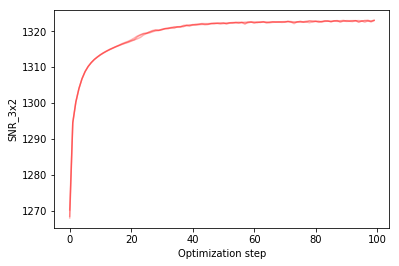

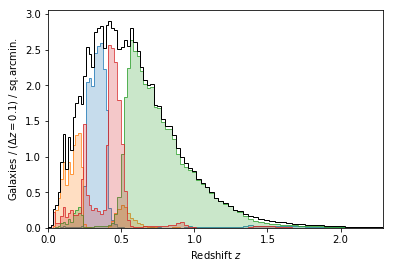

Starting job at 2020-09-11 17:42:09.737120 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1485.779 (max 1485.779) validation 1486.087.
Trial 1/3 epoch 11/100 train 1555.866 (max 1555.866) validation 1555.591.
Trial 1/3 epoch 21/100 train 1563.221 (max 1563.221) validation 1562.950.
Trial 1/3 epoch 31/100 train 1566.882 (max 1566.882) validation 1566.513.
Trial 1/3 epoch 41/100 train 1568.300 (max 1568.300) validation 1567.921.
Trial 1/3 epoch 51/100 train 1568.702 (max 1568.769) validation 1568.339.
Trial 1/3 epoch 61/100 train 1569.082 (max 1569.159) validation 1568.446.
Trial 1/3 epoch 71/100 train 1569.406 (max 1569.529) validation 1568.901.
Trial 1/3 epoch 81/100 train 1569.640 (max 1569.818) validation 1569.097.
Trial 1/3 epoch 91/100 train 1569.757 (max 1569.856) validation 1569.153.
Trial 2/3 epoch 1/100 train 1414.908 (max 1570.092) validatio

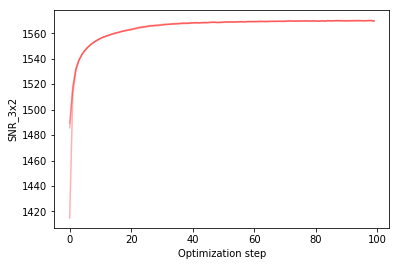

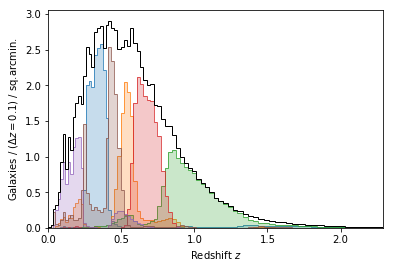

Starting job at 2020-09-11 17:46:10.180475 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1508.756 (max 1508.756) validation 1508.132.
Trial 1/3 epoch 11/100 train 1707.766 (max 1707.766) validation 1706.592.
Trial 1/3 epoch 21/100 train 1718.621 (max 1718.621) validation 1717.604.
Trial 1/3 epoch 31/100 train 1721.019 (max 1722.422) validation 1719.264.
Trial 1/3 epoch 41/100 train 1724.462 (max 1724.462) validation 1721.547.
Trial 1/3 epoch 51/100 train 1724.266 (max 1726.226) validation 1722.885.
Trial 1/3 epoch 61/100 train 1715.969 (max 1727.462) validation 1714.696.
Trial 1/3 epoch 71/100 train 1728.164 (max 1728.331) validation 1728.662.
Trial 1/3 epoch 81/100 train 1729.339 (max 1729.339) validation 1728.957.
Trial 1/3 epoch 91/100 train 1717.085 (max 1729.374) validation 1715.357.
Trial 2/3 epoch 1/100 train 1508.776 (max 1729.374) validatio

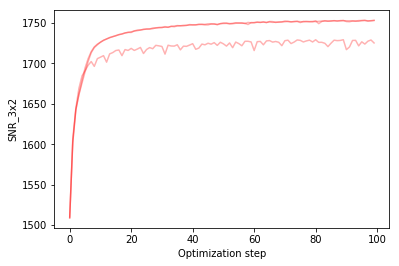

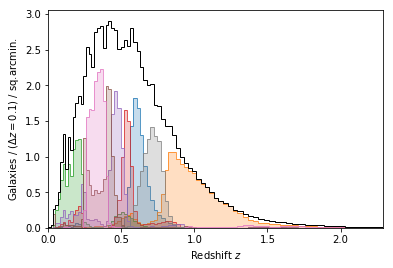

Starting job at 2020-09-11 17:51:04.373963 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'SNR_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 1560.250 (max 1560.250) validation 1558.925.
Trial 1/3 epoch 11/100 train 1850.066 (max 1850.066) validation 1850.552.
Trial 1/3 epoch 21/100 train 1875.487 (max 1875.487) validation 1875.646.
Trial 1/3 epoch 31/100 train 1883.622 (max 1883.622) validation 1883.409.
Trial 1/3 epoch 41/100 train 1888.014 (max 1888.014) validation 1888.196.
Trial 1/3 epoch 51/100 train 1889.305 (max 1889.305) validation 1889.079.
Trial 1/3 epoch 61/100 train 1891.175 (max 1891.539) validation 1889.850.
Trial 1/3 epoch 71/100 train 1892.300 (max 1892.633) validation 1891.597.
Trial 1/3 epoch 81/100 train 1891.906 (max 1893.401) validation 1891.278.
Trial 1/3 epoch 91/100 train 1894.433 (max 1894.433) validation 1893.443.
Trial 2/3 epoch 1/100 train 1559.718 (max 1894.756) validati

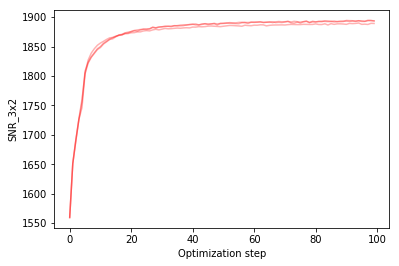

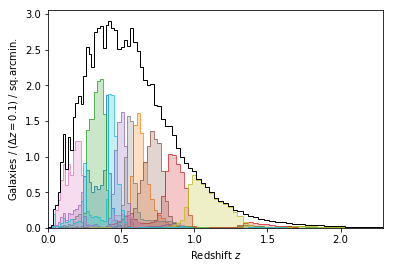

In [16]:
run_study('results/nn-3-64-snr', learn_nnet)

Starting job at 2020-09-11 17:58:56.687944 with {'nbin': 2, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 781.174 (max 781.174) validation 778.987.
Trial 1/3 epoch 11/100 train 870.176 (max 870.176) validation 866.091.
Trial 1/3 epoch 21/100 train 883.628 (max 884.484) validation 878.969.
Trial 1/3 epoch 31/100 train 889.770 (max 892.067) validation 885.836.
Trial 1/3 epoch 41/100 train 890.497 (max 894.688) validation 885.796.
Trial 1/3 epoch 51/100 train 895.126 (max 898.632) validation 892.633.
Trial 1/3 epoch 61/100 train 898.482 (max 899.777) validation 893.086.
Trial 1/3 epoch 71/100 train 962.989 (max 962.989) validation 972.378.
Trial 1/3 epoch 81/100 train 1445.025 (max 1445.025) validation 1441.974.
Trial 1/3 epoch 91/100 train 1445.434 (max 1454.804) validation 1443.901.
Trial 2/3 epoch 1/100 train 776.038 (max 1460.765) validation 773.344.
Trial 2/3 epoc

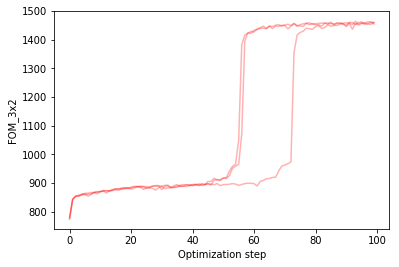

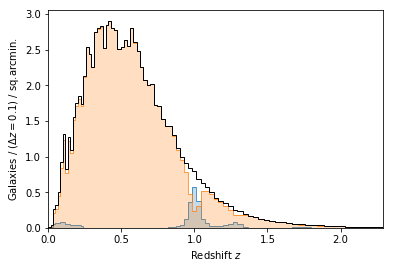

Starting job at 2020-09-11 18:00:48.707202 with {'nbin': 4, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 2944.069 (max 2944.069) validation 2978.222.
Trial 1/3 epoch 11/100 train 4716.083 (max 4716.083) validation 4727.660.
Trial 1/3 epoch 21/100 train 4810.548 (max 4837.535) validation 4822.096.
Trial 1/3 epoch 31/100 train 4824.322 (max 4888.326) validation 4865.926.
Trial 1/3 epoch 41/100 train 4899.093 (max 4906.111) validation 4888.434.
Trial 1/3 epoch 51/100 train 4903.043 (max 4923.519) validation 4906.102.
Trial 1/3 epoch 61/100 train 4930.163 (max 4930.163) validation 4939.589.
Trial 1/3 epoch 71/100 train 4918.558 (max 4936.199) validation 4930.351.
Trial 1/3 epoch 81/100 train 4941.172 (max 4941.172) validation 4953.047.
Trial 1/3 epoch 91/100 train 4930.487 (max 4941.172) validation 4937.974.
Trial 2/3 epoch 1/100 train 2939.110 (max 4967.338) validatio

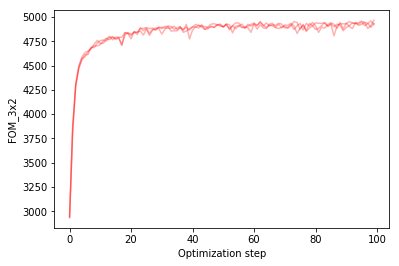

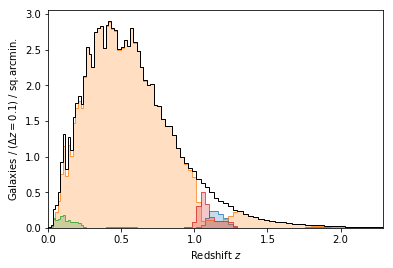

Starting job at 2020-09-11 18:03:06.651875 with {'nbin': 6, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 4198.789 (max 4198.789) validation 4215.817.
Trial 1/3 epoch 11/100 train 6387.057 (max 6387.057) validation 6415.665.
Trial 1/3 epoch 21/100 train 6534.121 (max 6551.967) validation 6546.233.
Trial 1/3 epoch 31/100 train 6541.627 (max 6607.701) validation 6529.586.
Trial 1/3 epoch 41/100 train 6611.508 (max 6611.508) validation 6620.569.
Trial 1/3 epoch 51/100 train 6647.223 (max 6653.990) validation 6642.059.
Trial 1/3 epoch 61/100 train 6676.467 (max 6698.930) validation 6670.853.
Trial 1/3 epoch 71/100 train 6681.460 (max 6715.458) validation 6683.449.
Trial 1/3 epoch 81/100 train 6716.201 (max 6728.189) validation 6704.740.
Trial 1/3 epoch 91/100 train 6688.103 (max 6728.189) validation 6691.434.
Trial 2/3 epoch 1/100 train 4190.964 (max 6762.592) validatio

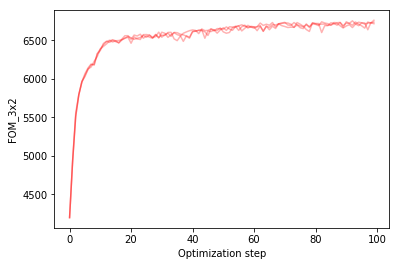

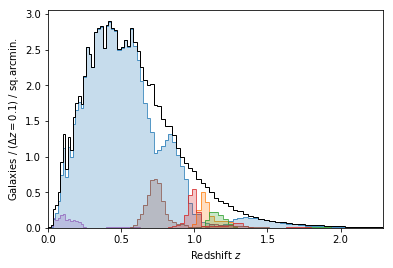

Starting job at 2020-09-11 18:07:12.825268 with {'nbin': 8, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 5048.070 (max 5048.070) validation 5068.040.
Trial 1/3 epoch 11/100 train 7890.438 (max 7890.438) validation 7852.574.
Trial 1/3 epoch 21/100 train 8022.166 (max 8100.405) validation 8042.182.
Trial 1/3 epoch 31/100 train 8229.599 (max 8292.144) validation 8216.973.
Trial 1/3 epoch 41/100 train 8398.334 (max 8398.334) validation 8384.122.
Trial 1/3 epoch 51/100 train 8395.260 (max 8406.772) validation 8403.326.
Trial 1/3 epoch 61/100 train 8404.568 (max 8438.429) validation 8383.419.
Trial 1/3 epoch 71/100 train 8440.400 (max 8446.464) validation 8452.709.
Trial 1/3 epoch 81/100 train 8475.795 (max 8475.795) validation 8463.654.
Trial 1/3 epoch 91/100 train 8498.709 (max 8498.709) validation 8489.216.
Trial 2/3 epoch 1/100 train 5052.487 (max 8498.709) validatio

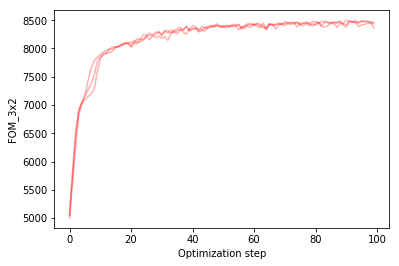

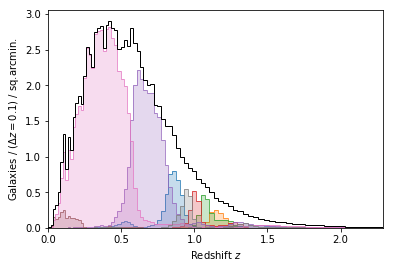

Starting job at 2020-09-11 18:12:14.937317 with {'nbin': 10, 'trainfrac': 0.9, 'batchsize': 50000, 'ntrial': 3, 'nhidden': 64, 'nlayer': 3, 'nepoch': 100, 'eta': 0.001, 'metric': 'FOM_3x2', 'seed': 1}
Trial 1/3 epoch 1/100 train 5847.883 (max 5847.883) validation 5887.355.
Trial 1/3 epoch 11/100 train 9058.173 (max 9058.173) validation 9048.098.
Trial 1/3 epoch 21/100 train 9392.799 (max 9392.799) validation 9397.278.
Trial 1/3 epoch 31/100 train 9381.430 (max 9435.588) validation 9386.208.
Trial 1/3 epoch 41/100 train 9462.216 (max 9483.229) validation 9442.357.
Trial 1/3 epoch 51/100 train 9568.450 (max 9581.929) validation 9585.447.
Trial 1/3 epoch 61/100 train 9630.942 (max 9657.910) validation 9617.396.
Trial 1/3 epoch 71/100 train 9651.833 (max 9698.447) validation 9643.663.
Trial 1/3 epoch 81/100 train 9725.084 (max 9725.084) validation 9710.219.
Trial 1/3 epoch 91/100 train 9680.548 (max 9733.603) validation 9661.725.
Trial 2/3 epoch 1/100 train 5834.357 (max 9748.549) validati

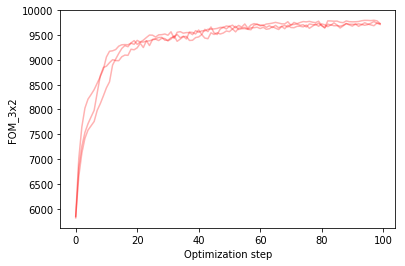

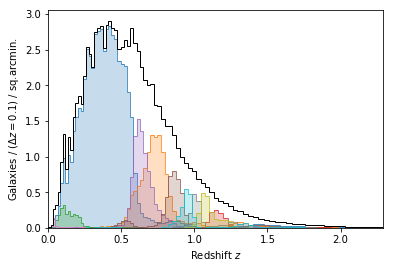

In [17]:
run_study('results/nn-3-64-fom', learn_nnet)

## Sandbox

Assign bin labels to a sample based on optimized weights:

In [67]:
def get_labels(z, w, seed=1):
    nds = len(zds) - 1
    gen = np.random.RandomState(seed)
    # Assign each redshift to an input redshift bin.
    idx = np.clip(np.digitize(z, zds) - 1, 0, nds - 1)
    # Calculate the CDF for mapping each input bin to output bins.
    cdf = np.cumsum(w, axis=0)
    cdf /= cdf[-1]
    # Loop over input bins to assign output bins sampled from the CDF.
    labels = np.empty(len(z), int)
    for i in range(nds):
        sel = idx == i
        nsel = np.count_nonzero(sel)
        u = gen.uniform(size=nsel)
        labels[sel] = np.searchsorted(cdf[:, i], u)
    return labels
    
labels4 = get_labels(zbuz, wbest4)

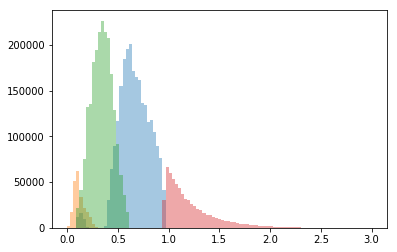

In [68]:
def plot_labels(z, labels):
    nbin = labels.max() + 1
    for i in range(nbin):
        sel = labels == i
        plt.hist(z[sel], bins=np.linspace(0, 3, 100), histtype='stepfilled', alpha=0.4)
        
plot_labels(zbuz, labels4)

In [69]:
np.save('buzzard_labels4.npy', labels4.astype(np.uint8))